# An Analysis of Wind Speeds in the North Sea

---

### Data

We will be working with [data](https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/10_minutes/) collected by [DWD](https://dwd.de) on Helgoland in a 10-minute intervall from 1996 to 2022. For loading the data, we have to manually collect the from a http server.


### Imports and Usage

You can simply use the `environment.yml` file to create a new conda environment with all the needed packages by running `conda env create -f environment.yml`. The only relevant parameter you may want to change is `RELOAD`. If set to `True`, all the needed data will be downloaded and saved in the `data/` folder.

## Data Loading

In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
import datetime as dt
import matplotlib.dates as mdt
from tueplots import bundles
import tueplots as tp
import tueplots.constants.color as tpc
import math
from datetime import datetime
import pyhomogeneity as hg

import scipy.optimize as opt
import scipy.integrate
import scipy


from sklearn.gaussian_process import GaussianProcessRegressor as GP
import sklearn.gaussian_process.kernels as GPK
import joypy as jpy
import os

import sys
sys.path.append("../util/")
from dataloader import Loader
from weibull import Weibull
from dates import days_to_date
from ridgeline_plot import ridgeline_plot


from helpers import plot_timeframe, plot_timeframe_pdf, yearly_params, monthly_params


plt.rcParams.update(bundles.beamer_moml())
plt.rcParams['figure.dpi'] = 400
plt.rcParams["font.family"] = "DejaVu Sans"

# set true to download the data and unzip into the current directory
RELOAD = False
ZIP_NAME = "data.zip"
DATA_FOLDER = "../data"

DATA_BASE_URL = "https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/10_minutes/"
METRICS = ["wind", "air_temperature", "precipitation", "solar"]
METRIC_URLS = [DATA_BASE_URL + postfix + "/historical/" for postfix in METRICS]
print(METRIC_URLS)

['https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/10_minutes/wind/historical/', 'https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/10_minutes/air_temperature/historical/', 'https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/10_minutes/precipitation/historical/', 'https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/10_minutes/solar/historical/']


In [4]:
loader = Loader(METRICS, DATA_FOLDER)
metric_files = loader.download_all_metrics(reset=False)

for kind in METRICS:
    print(f"Files containing {kind} data:\n\t{metric_files[kind]}")

kind_df, df = loader.as_dataframe

Files containing wind data:
	['c:\\Users\\gwend\\Uni\\WiSe23\\DataLiteracy\\DataLiteracyProject\\data\\wind\\produkt_zehn_min_ff_19961220_19991231_02115.txt', 'c:\\Users\\gwend\\Uni\\WiSe23\\DataLiteracy\\DataLiteracyProject\\data\\wind\\produkt_zehn_min_ff_20000101_20091231_02115.txt', 'c:\\Users\\gwend\\Uni\\WiSe23\\DataLiteracy\\DataLiteracyProject\\data\\wind\\produkt_zehn_min_ff_20100101_20191231_02115.txt', 'c:\\Users\\gwend\\Uni\\WiSe23\\DataLiteracy\\DataLiteracyProject\\data\\wind\\produkt_zehn_min_ff_20200101_20221231_02115.txt']
Files containing air_temperature data:
	['c:\\Users\\gwend\\Uni\\WiSe23\\DataLiteracy\\DataLiteracyProject\\data\\air_temperature\\produkt_zehn_min_tu_19961219_19991231_02115.txt', 'c:\\Users\\gwend\\Uni\\WiSe23\\DataLiteracy\\DataLiteracyProject\\data\\air_temperature\\produkt_zehn_min_tu_20000101_20091231_02115.txt', 'c:\\Users\\gwend\\Uni\\WiSe23\\DataLiteracy\\DataLiteracyProject\\data\\air_temperature\\produkt_zehn_min_tu_20100101_20191231_02115

In [5]:
# print(df.dtypes)
for metric, metric_df in kind_df.items():
    print(metric_df.dtypes)

STATIONS_ID             int64
MESS_DATUM     datetime64[ns]
  QN_wind               int64
FF_10_wind            float64
DD_10_wind            float64
eor_wind               object
dtype: object
STATIONS_ID                        int64
MESS_DATUM                datetime64[ns]
QN_air_temperature               float64
PP_10_air_temperature            float64
TT_10_air_temperature            float64
TM5_10_air_temperature           float64
RF_10_air_temperature            float64
TD_10_air_temperature            float64
  QN_air_temperature             float64
eor_air_temperature               object
dtype: object
STATIONS_ID                          int64
MESS_DATUM                  datetime64[ns]
QN_precipitation                   float64
RWS_DAU_10_precipitation           float64
RWS_10_precipitation               float64
RWS_IND_10_precipitation           float64
  QN_precipitation                 float64
eor_precipitation                   object
dtype: object
STATIONS_ID             

## Preprocessing

In [6]:
wind_df = kind_df["wind"]
wind_df["year"] = wind_df["MESS_DATUM"].dt.year
wind_df["month"] = wind_df["MESS_DATUM"].dt.month
wind_df["day"] = wind_df["MESS_DATUM"].dt.day

# First, get rid of NaNs

# a bit more than one year across all years is missing (~ 58000 days)
print(f"#NaNs: {wind_df['FF_10_wind'].isna().sum()}")
print(wind_df[(wind_df["FF_10_wind"].isna())].groupby("year")["STATIONS_ID"].agg("count").reset_index())
wind_df.dropna(subset=["FF_10_wind"], inplace=True)
wind_df = wind_df[wind_df["FF_10_wind"] != -999]

#NaNs: 58194
    year  STATIONS_ID
0   2000            4
1   2001           10
2   2002           30
3   2003            5
4   2007            8
5   2009          217
6   2013         1578
7   2014           62
8   2015          196
9   2016         1056
10  2017         1040
11  2018         4868
12  2019        46074
13  2020          950
14  2021         1819
15  2022          277


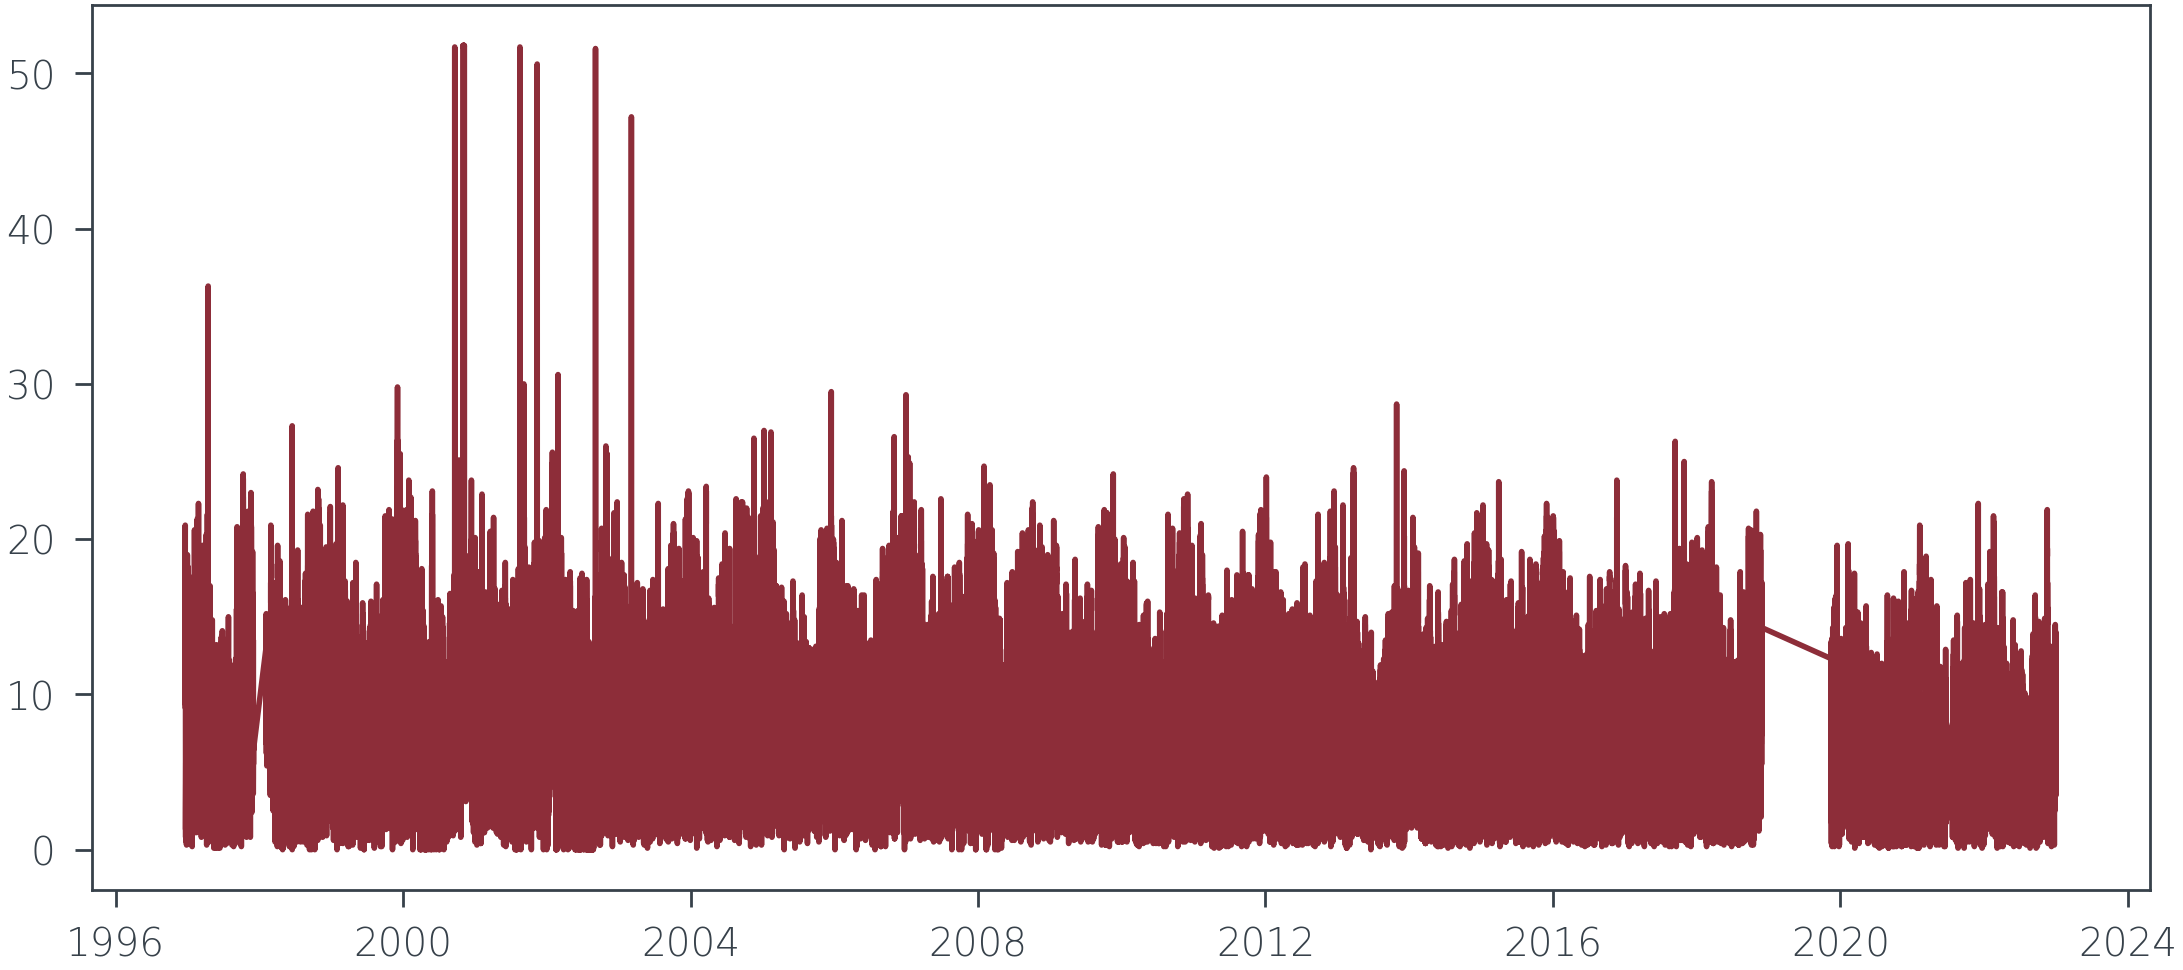

In [7]:
# there are still some outlier left
plt.plot("MESS_DATUM", "FF_10_wind", data=wind_df)
plt.show()

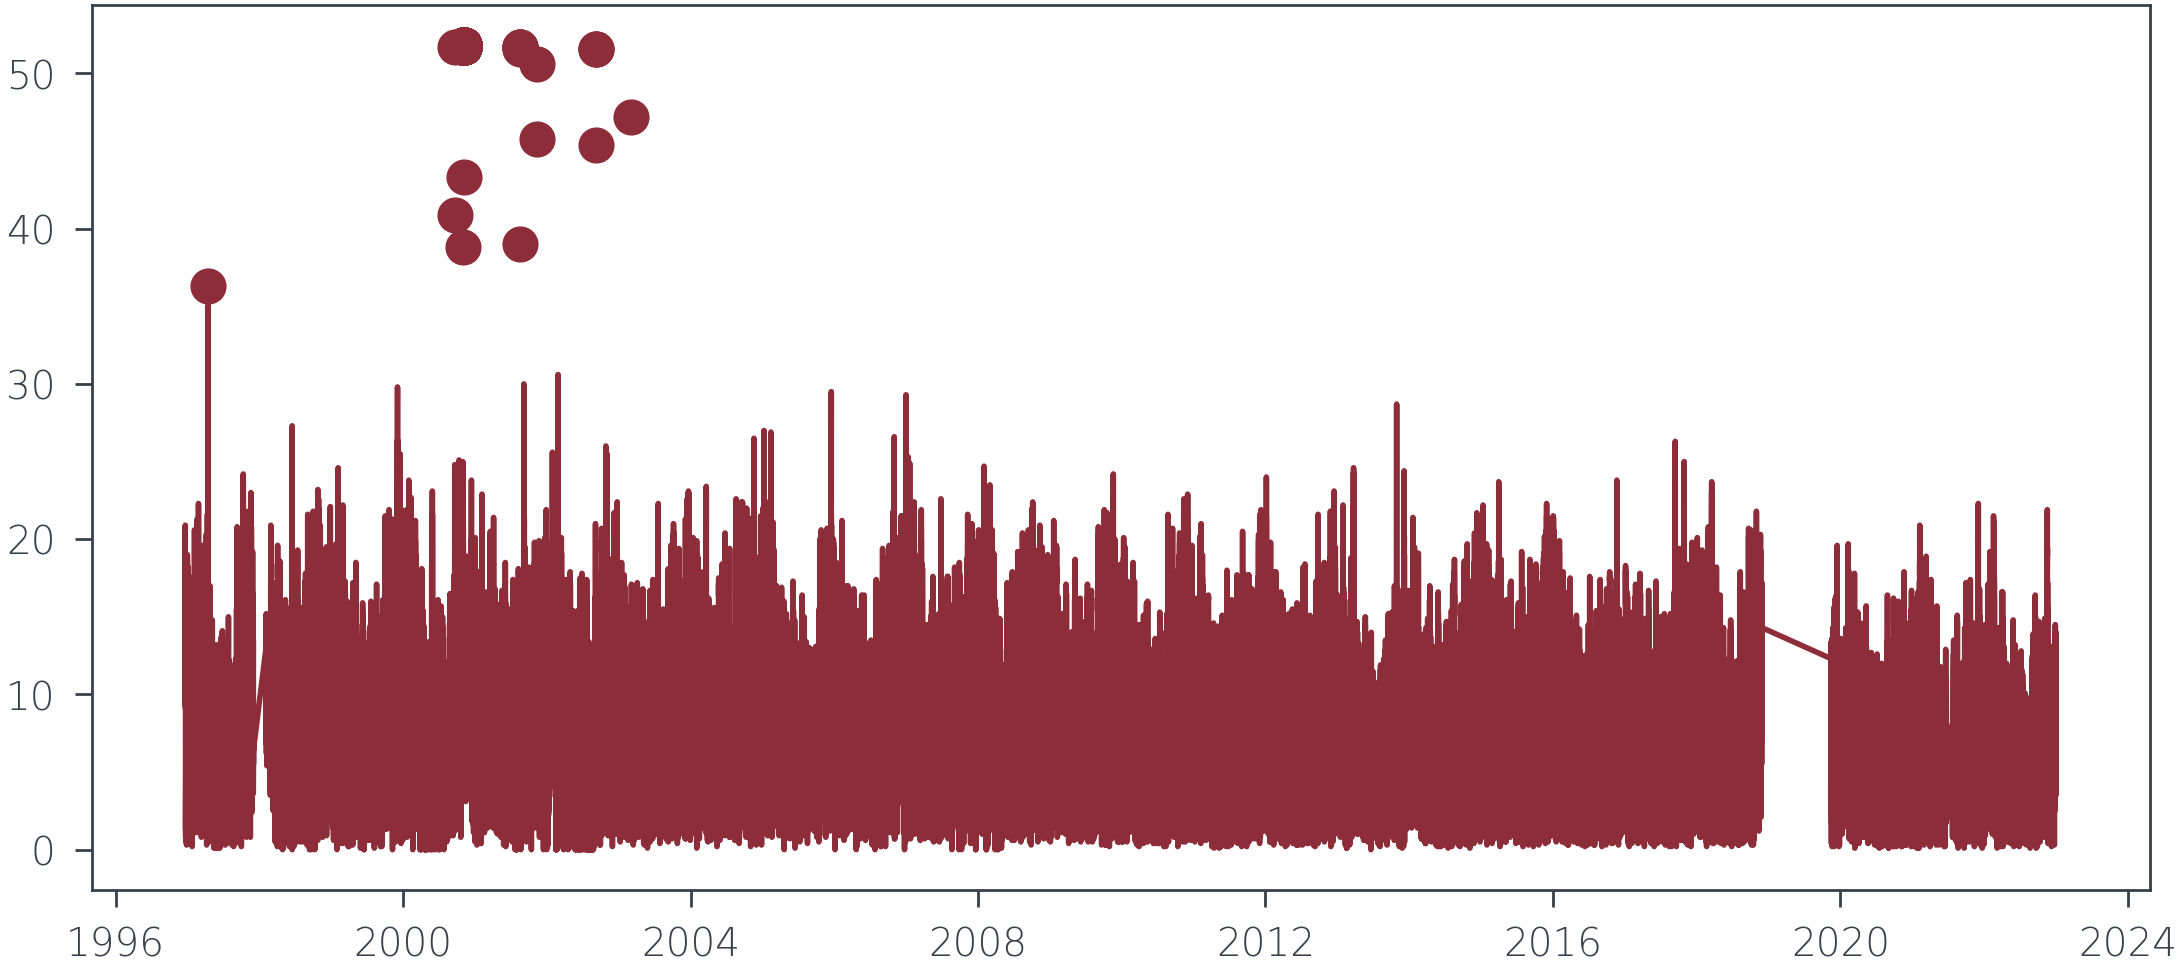

In [8]:
zscores = scipy.stats.zscore(wind_df["FF_10_wind"])
threshold = 7
plt.scatter("MESS_DATUM", "FF_10_wind", data=wind_df[zscores > threshold])
plt.plot("MESS_DATUM", "FF_10_wind", data=wind_df[zscores <= threshold])
wind_df = wind_df[zscores < 8]

## Explorative Data Analysis

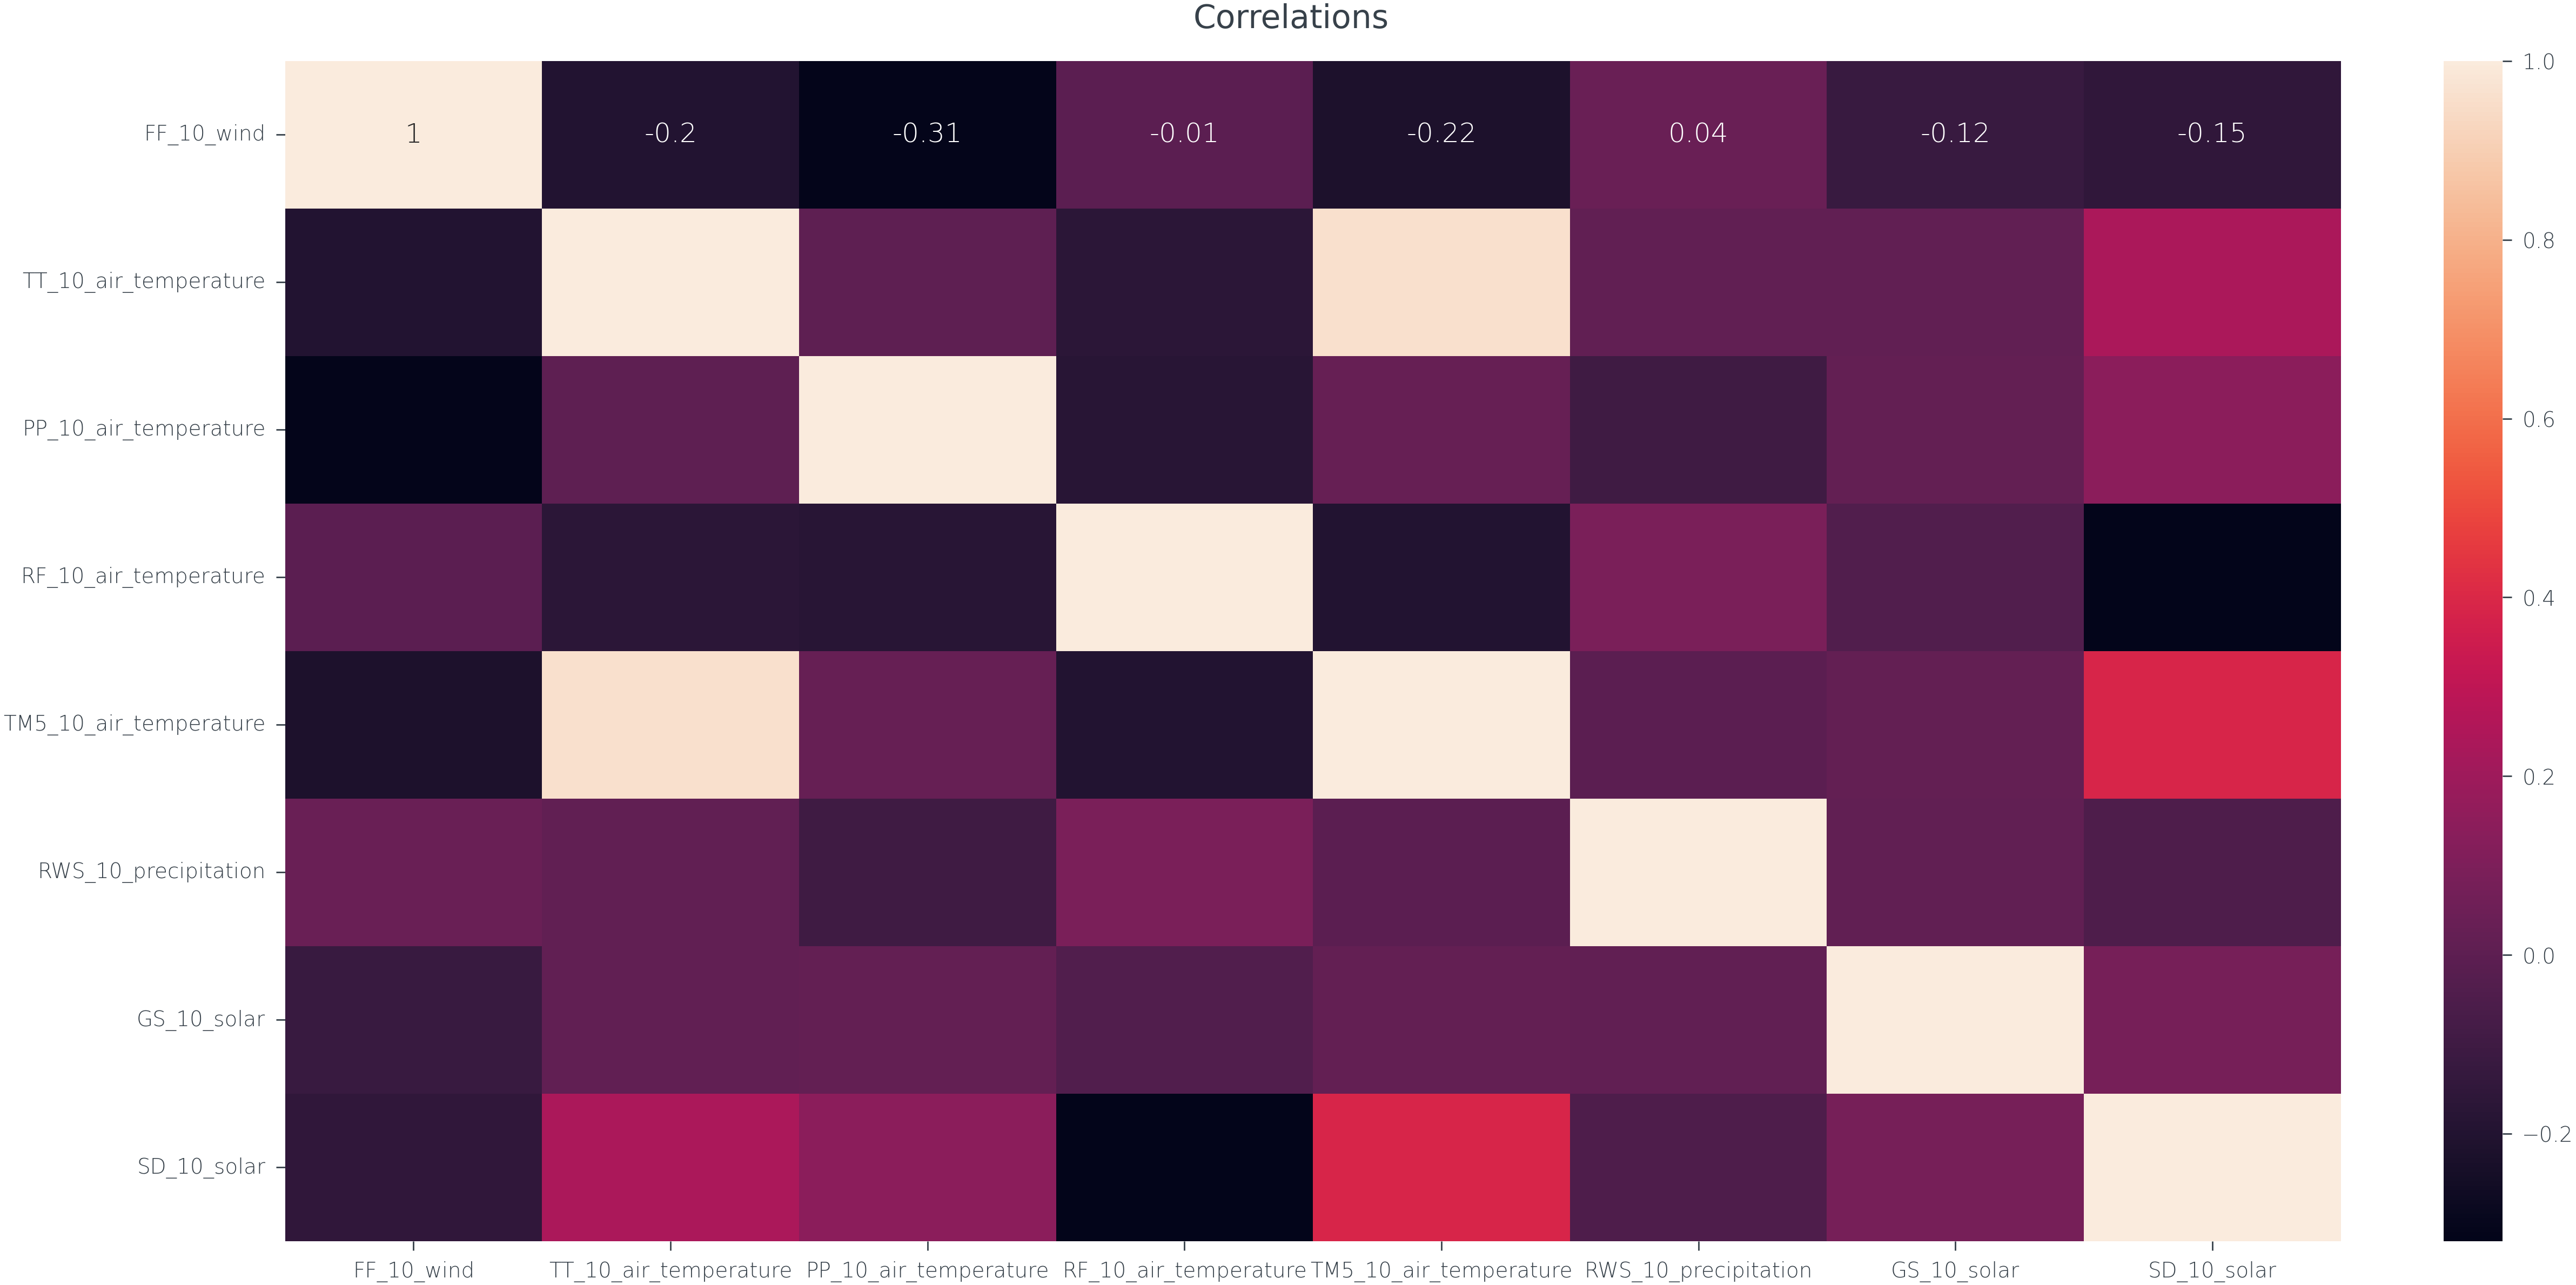

In [9]:
fig, ax = plt.subplots(figsize=(12, 6))
corr = df[["FF_10_wind", "TT_10_air_temperature", "PP_10_air_temperature", "RF_10_air_temperature", "TM5_10_air_temperature", "RWS_10_precipitation", "GS_10_solar", "SD_10_solar"]].corr().round(2)
ax = sns.heatmap(corr, annot=True)
fig.suptitle("Correlations")
plt.show()

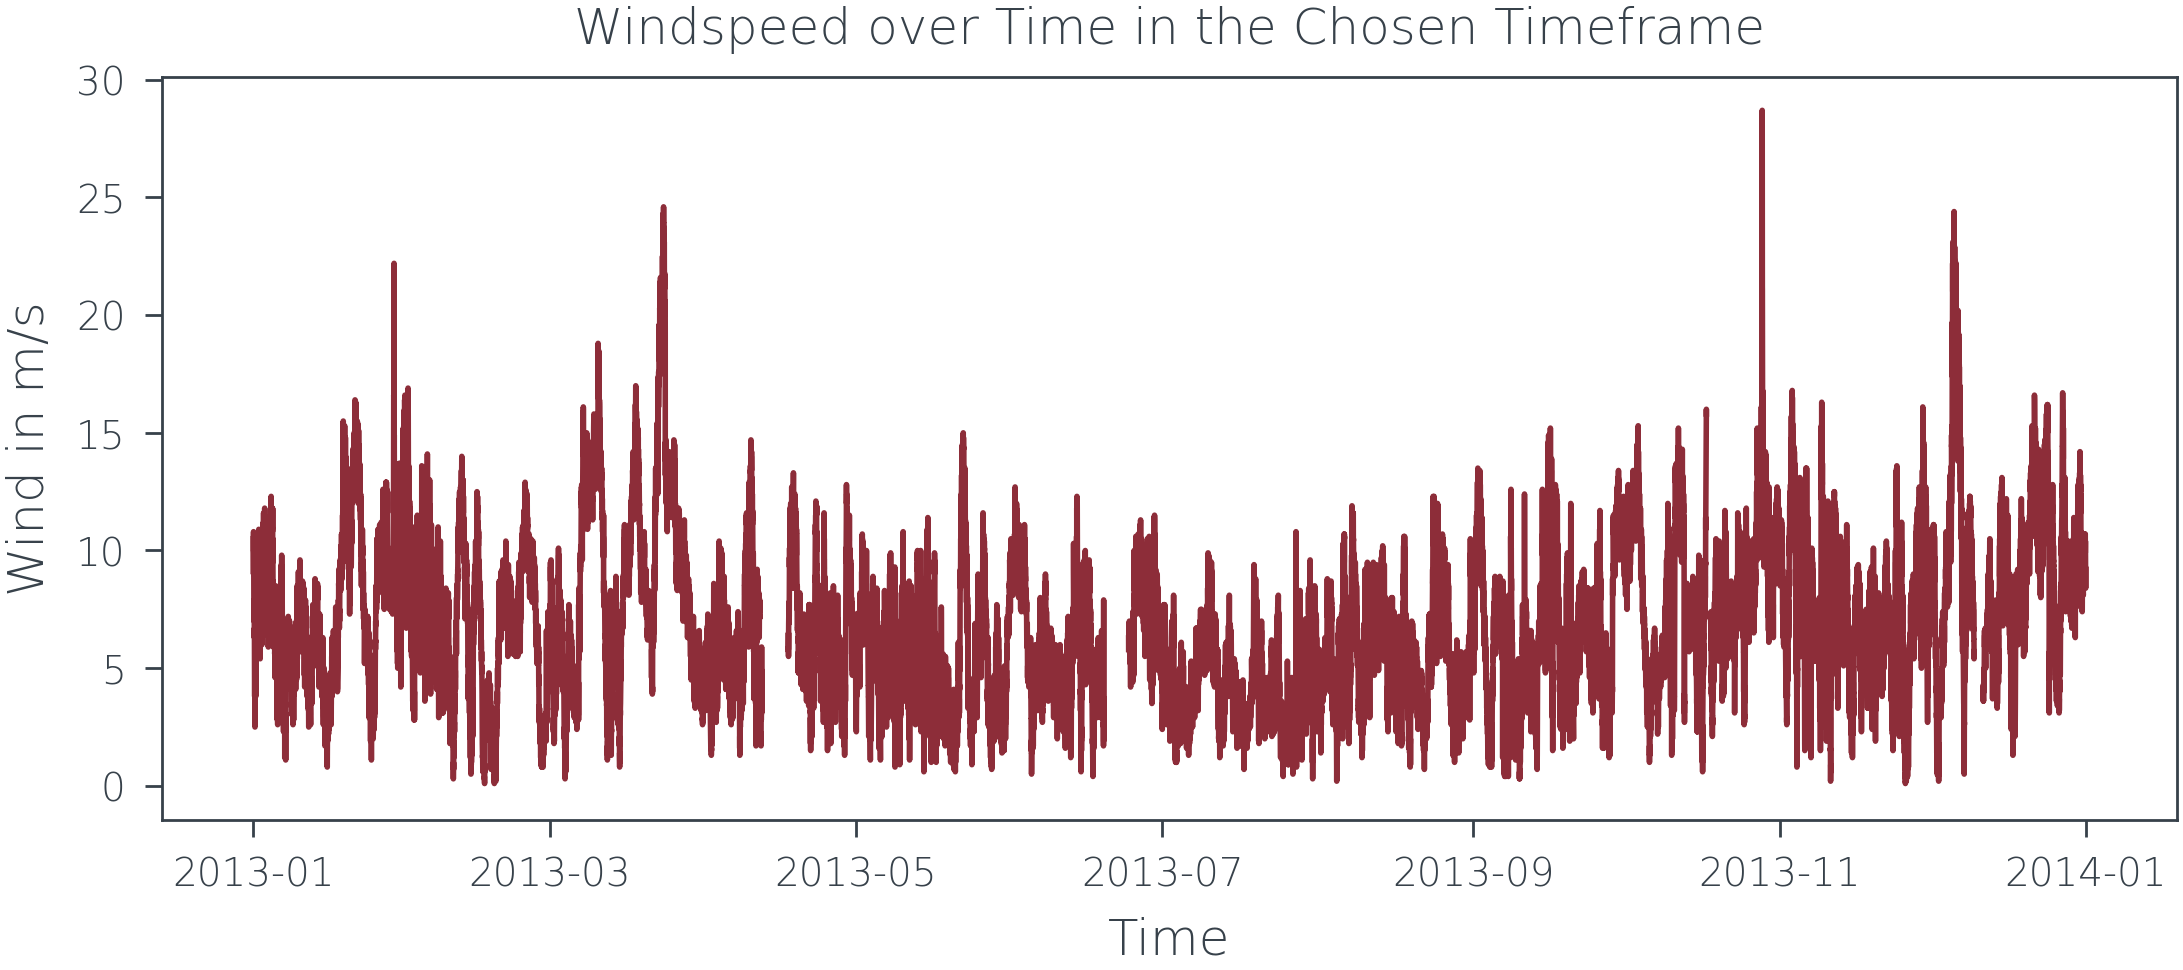

In [10]:
# plot exemplary a chosen timeframe
plot_timeframe(df, 2013)

findfont: Font family ['sans'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans' not found because none of the following families were found: Roboto Condensed
findfont: Font family ['sans'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans' not found because none of the following families were found: Roboto Condensed
findfont: Font family ['sans'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans' not found because none of the following families were found: Roboto Condensed
findfont: Font family ['sans'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans' not found because none of the following families were found: Roboto Condensed


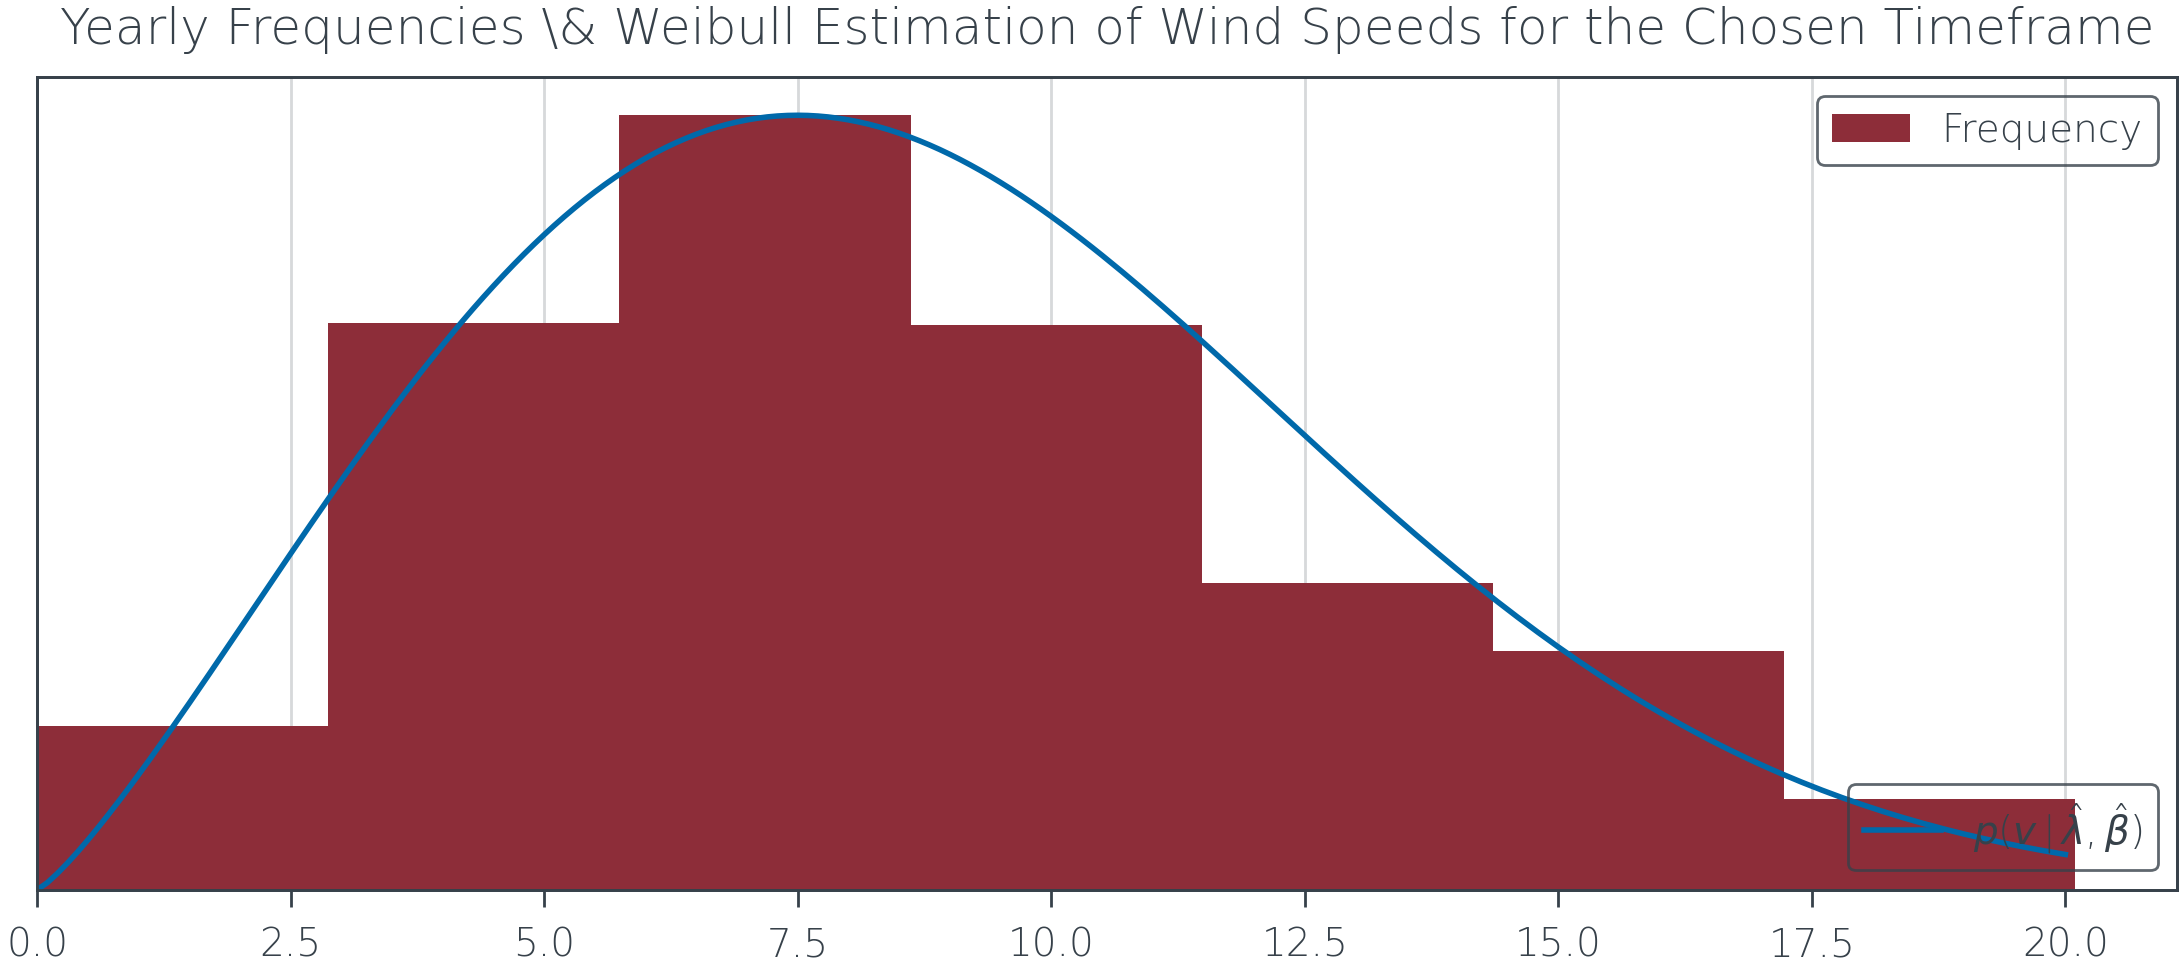

In [11]:
# plot the empiric pdf and the estimated weibull distribution for a chosen timeframe
plot_timeframe_pdf(df, 2002,3)

In [12]:
# compute the weibull parameters for all months and years
yearly_df=yearly_params(1997, 2018, wind_df)
monthly_df=monthly_params(1997, 2018, wind_df)

Text(0, 0.5, '$\\mathrm{p}(\\mathrm{v} \\mid \\hat{\\lambda}, \\hat{\\beta})$')

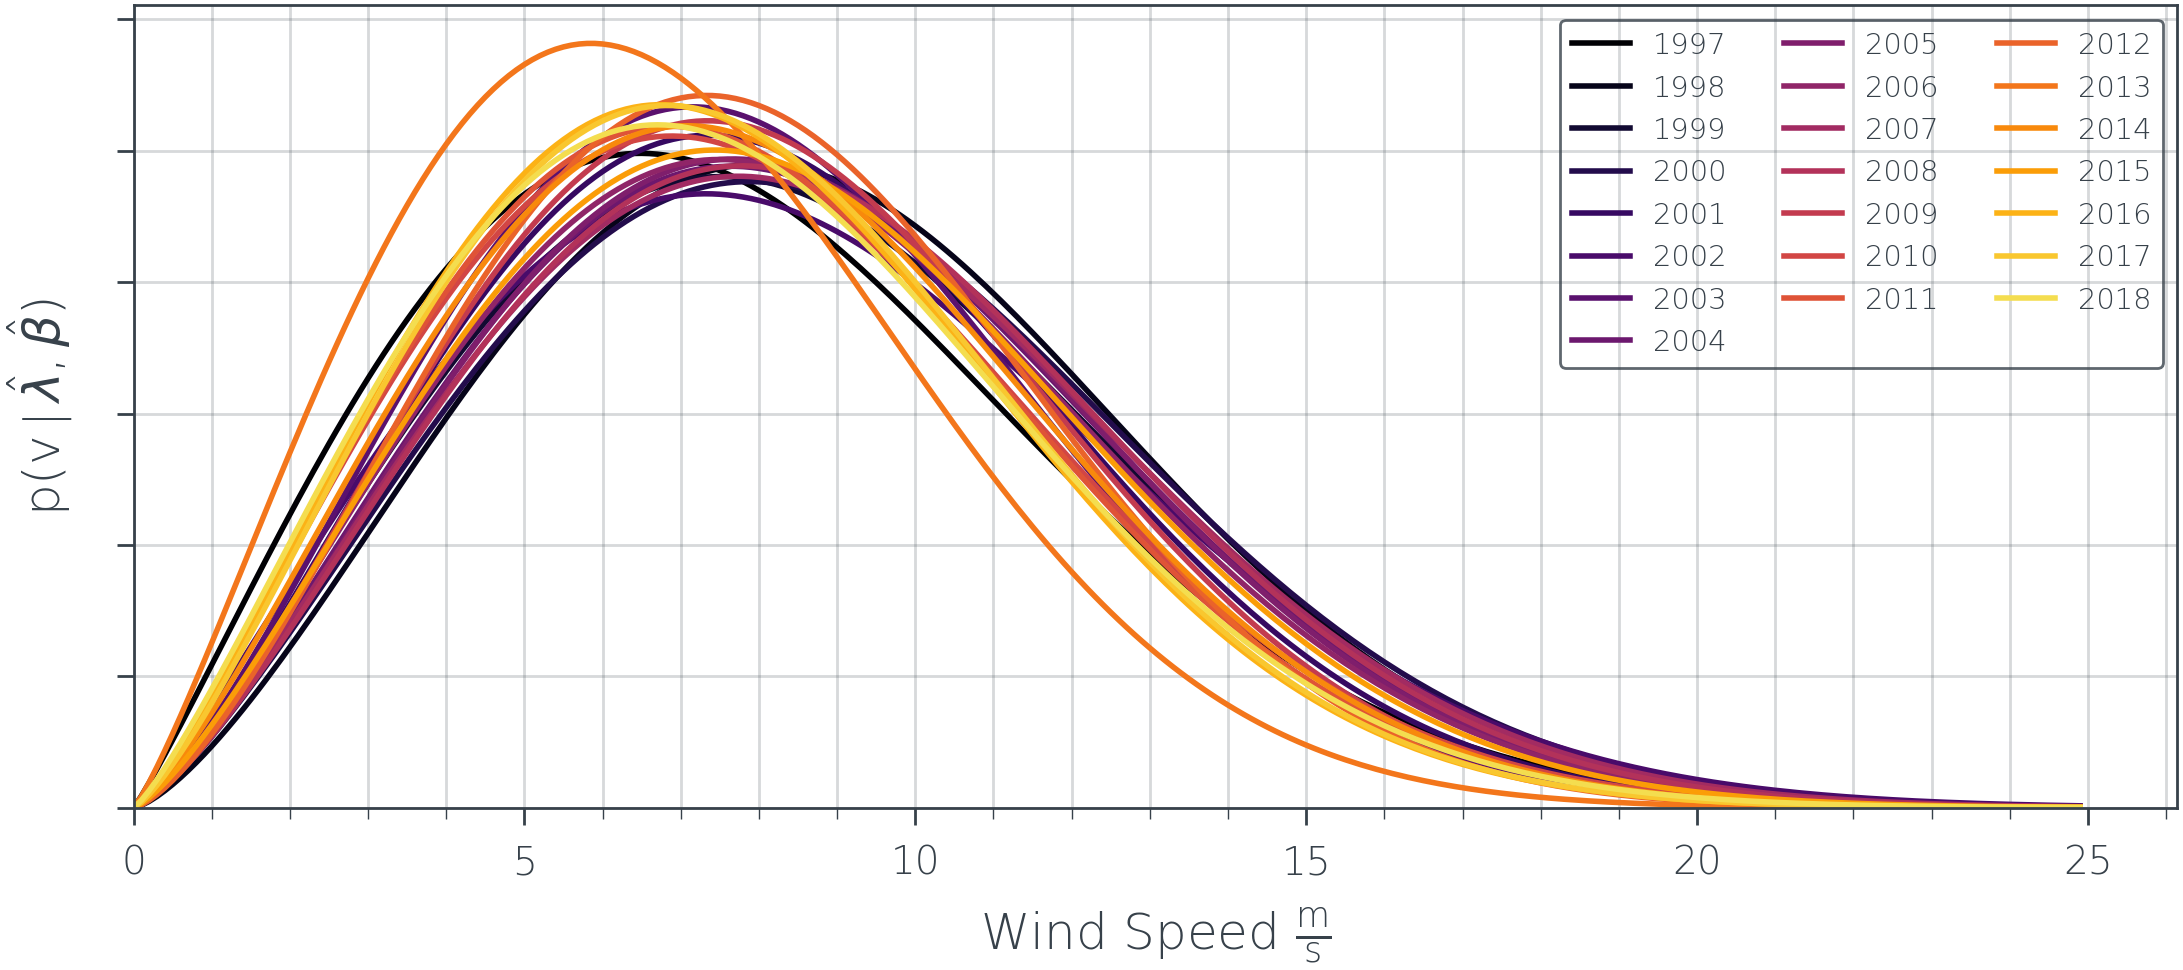

In [13]:
# plot the estimated weibull distribution for each year
fig, ax = plt.subplots(1, 1)
year_colors = plt.cm.inferno(np.linspace(0,1,24))
for year in yearly_df.index:
    X = np.arange(0, 25, 0.1)
    weibull = Weibull(yearly_df.loc[year, 'param_lambda'],yearly_df.loc[year, 'param_beta'] )
    ax.plot(X, weibull.pdf(X), label=year, color= year_colors[year-1997])
    # ax.axvline(weibull.mean, ls="-.", linewidth=0.25)
    
ax.grid(which="both")
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(1.0))
ax.set_yticklabels([])
ax.set_xlim(0)
ax.set_ylim(0)
ax.legend(ncols=(2022 - 1996) / 8, fontsize="xx-small")
ax.set_xlabel(r"Wind Speed $\frac{\mathrm{m}}{\mathrm{s}}$")
ax.set_ylabel(r"$\mathrm{p}(\mathrm{v} \mid \hat{\lambda}, \hat{\beta})$")

In [14]:

wind_year_dists = []
for year, year_month_df in wind_df.groupby("year"):
    if year == 2019:
        continue
    Y = year_month_df["FF_10_wind"].dropna().copy()
    weibull = Weibull.estimate(Y)
    wind_year_dists.append([year, Y, weibull])
wind_year_dists = pd.DataFrame(wind_year_dists, columns=["year", "data", "weibull"])
#wind_year_dists

In [15]:
wind_month_pdfs = []
for (year, month), year_month_df in wind_df.groupby(["year", "month"]):
    X = year_month_df["FF_10_wind"].dropna().copy()
    weibull = Weibull.estimate(X)
    wind_month_pdfs.append([year, month, weibull, X])
wind_month_pdfs = pd.DataFrame(wind_month_pdfs, columns=["year", "month", "weibull", "wind"])
#wind_month_pdfs
        

# Test the new utils out


In [16]:
from get_params import yearly_params
from get_params import monthly_params

yearly_df=yearly_params(1997, 2022, wind_df)
monthly_df=monthly_params(1997, 2022, wind_df)

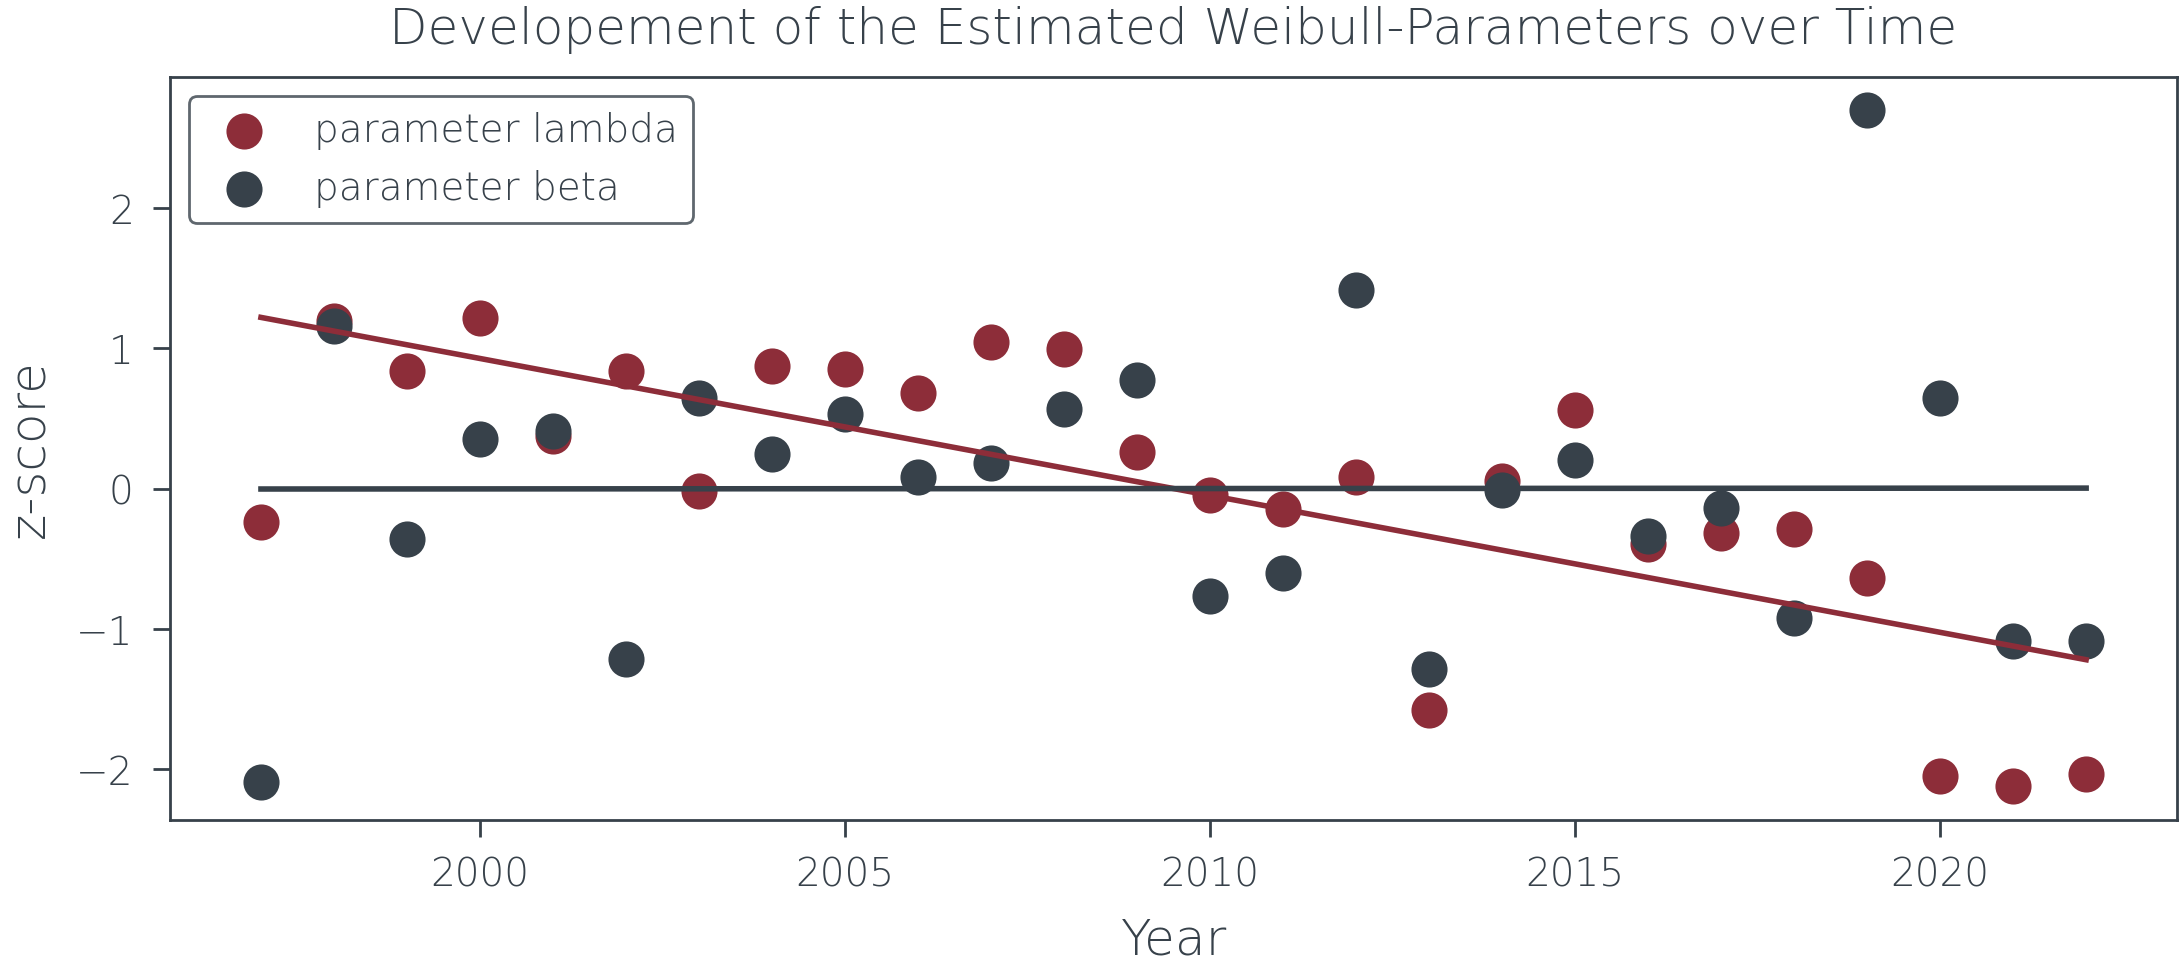

In [17]:

plt.scatter(yearly_df.index, (yearly_df['param_lambda'] -yearly_df['param_lambda'].mean())/yearly_df['param_lambda'].std(), label='parameter lambda' )
plt.scatter(yearly_df.index, (yearly_df['param_beta'] -yearly_df['param_beta'].mean())/yearly_df['param_beta'].std(), label='parameter beta' )

l_pol=np.polyfit(yearly_df.index,(yearly_df['param_lambda'] -yearly_df['param_lambda'].mean())/yearly_df['param_lambda'].std(), 1)
l_model = np.poly1d(l_pol)
plt.plot(yearly_df.index,l_model(yearly_df.index))

b_pol=np.polyfit(yearly_df.index,(yearly_df['param_beta'] -yearly_df['param_beta'].mean())/yearly_df['param_lambda'].std(), 1)
b_model = np.poly1d(b_pol)
plt.plot(yearly_df.index,b_model(yearly_df.index))

plt.title('Developement of the Estimated Weibull-Parameters over Time')
plt.xlabel('Year')
plt.ylabel('z-score')
plt.legend()
plt.show()

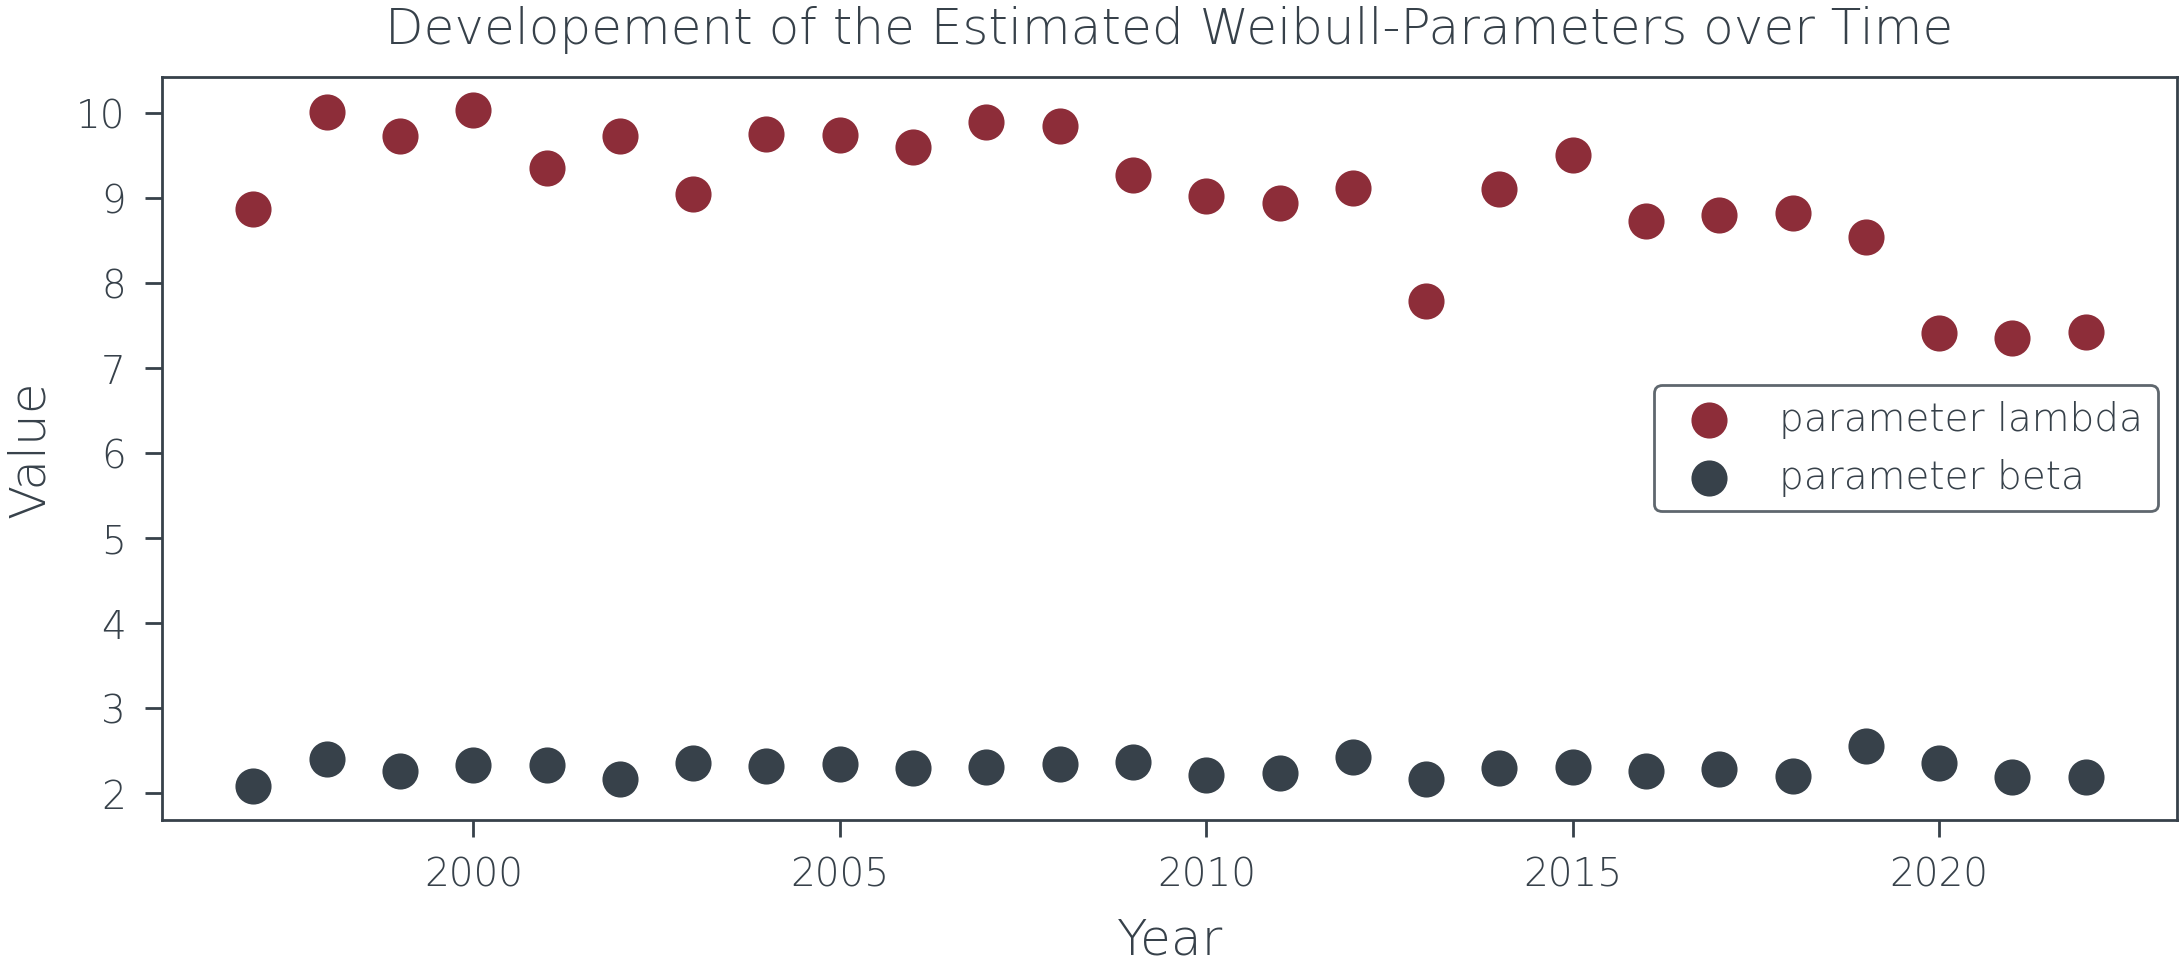

In [18]:
plt.scatter(yearly_df.index, yearly_df['param_lambda'], label='parameter lambda' )
plt.scatter(yearly_df.index, yearly_df['param_beta'], label='parameter beta' )

plt.title('Developement of the Estimated Weibull-Parameters over Time')
plt.xlabel('Year')
plt.ylabel('Value')
plt.legend()
plt.show()

number of bins for fitting is 23
number of bins for fitting is 23
number of bins for fitting is 23
number of bins for fitting is 22
number of bins for fitting is 22
number of bins for fitting is 22
number of bins for fitting is 24
number of bins for fitting is 24
number of bins for fitting is 24
number of bins for fitting is 24
number of bins for fitting is 24
number of bins for fitting is 24
number of bins for fitting is 24
number of bins for fitting is 24
number of bins for fitting is 24
number of bins for fitting is 24
number of bins for fitting is 24
number of bins for fitting is 24
number of bins for fitting is 24
number of bins for fitting is 24
number of bins for fitting is 24
number of bins for fitting is 24
number of bins for fitting is 24
number of bins for fitting is 24
number of bins for fitting is 24
number of bins for fitting is 24
number of bins for fitting is 24
number of bins for fitting is 24
number of bins for fitting is 24
number of bins for fitting is 24
number of 

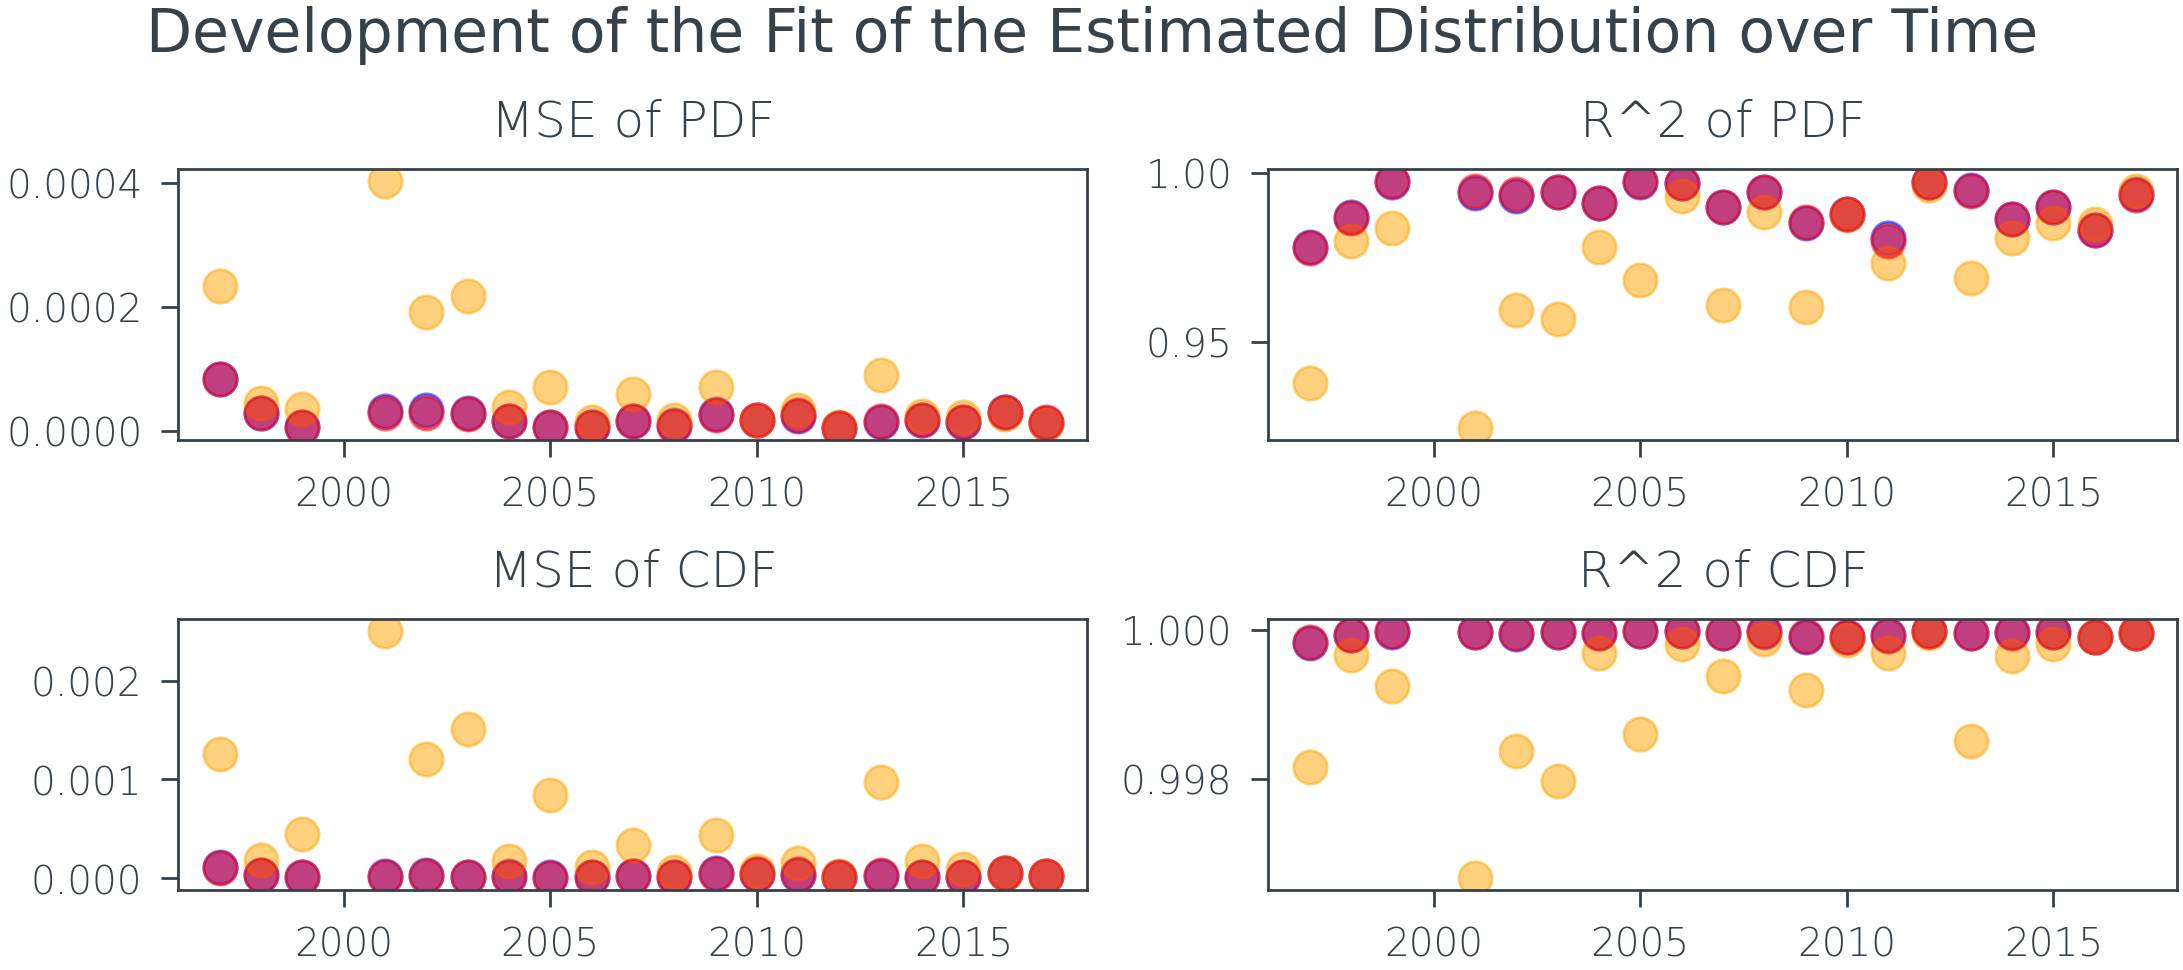

In [19]:
# how does the goodness of fit develop over time (yearly)?

figure, axis = plt.subplots(2, 2)

for y in range(1997, 2018):
    if y==2000 or y==2019:
        continue
    mle_weibull=Weibull.estimate(df[(df['MESS_DATUM'].dt.year == y)]["FF_10_wind"])
    graphical_weibull=Weibull.graphical_estimate(df[(df['MESS_DATUM'].dt.year == y)]["FF_10_wind"])
    epf_weibull=Weibull.epf_estimate(df[(df['MESS_DATUM'].dt.year == y)]["FF_10_wind"])
    
    fit1= mle_weibull.fit(df[(df['MESS_DATUM'].dt.year == y)]["FF_10_wind"])
    fit2=graphical_weibull.fit(df[(df['MESS_DATUM'].dt.year == y)]["FF_10_wind"])
    fit3=epf_weibull.fit(df[(df['MESS_DATUM'].dt.year == y)]["FF_10_wind"])


    axis[0,0].scatter(y,fit1[0], color='blue', alpha=0.5 , label='MLM') 
    axis[0,0].scatter(y, fit2[0], color='orange', alpha=0.5, label='graphical method')
    axis[0,0].scatter(y, fit3[0], color='red', alpha=0.5, label='epf method')
    axis[0, 0].set_title("MSE of PDF")

    axis[1,0].scatter(y, fit1[1], color='blue', alpha=0.5) 
    axis[1,0].scatter(y, fit2[1], color='orange', alpha=0.5)
    axis[1,0].scatter(y, fit3[1], color='red', alpha=0.5)
    axis[1, 0].set_title("MSE of CDF")

    axis[0,1].scatter(y, fit1[2], color='blue', alpha=0.5) 
    axis[0,1].scatter(y, fit2[2], color='orange', alpha=0.5)
    axis[0,1].scatter(y, fit3[2], color='red', alpha=0.5)
    axis[0, 1].set_title("R^2 of PDF")

    axis[1,1].scatter(y, fit1[3], color='blue', alpha=0.5) 
    axis[1,1].scatter(y, fit2[3], color='orange', alpha=0.5)
    axis[1,1].scatter(y, fit3[3], color='red', alpha=0.5)
    axis[1, 1].set_title("R^2 of CDF")

figure.suptitle('Development of the Fit of the Estimated Distribution over Time')
#plt.xlabel('Year')
#plt.ylabel('Fit')
#plt.legend()
plt.show()

In [20]:
# contains the daily average windspeed starting in the 1950s
early_df = pd.read_csv(
    "FG_STAID000468.csv",
    skiprows=19,
    sep=",",
    index_col=None,
    skipfooter=0,
    engine="python",
)
# convert the date and divide the windspeed by 10, so it's given in m/s
early_df['DATE']=pd.to_datetime(early_df["DATE"], format="%Y%m%d")
early_df['FG']=early_df['FG']/10


#compute the yearly mean

mean_df=pd.DataFrame(index=np.arange(1959, 2024), columns=['Mean']) 
F=early_df[early_df['FG']>0]
for y in mean_df.index:
    mean_df.loc[y, 'Mean']=F[F['DATE'].dt.year==y]['FG'].mean()

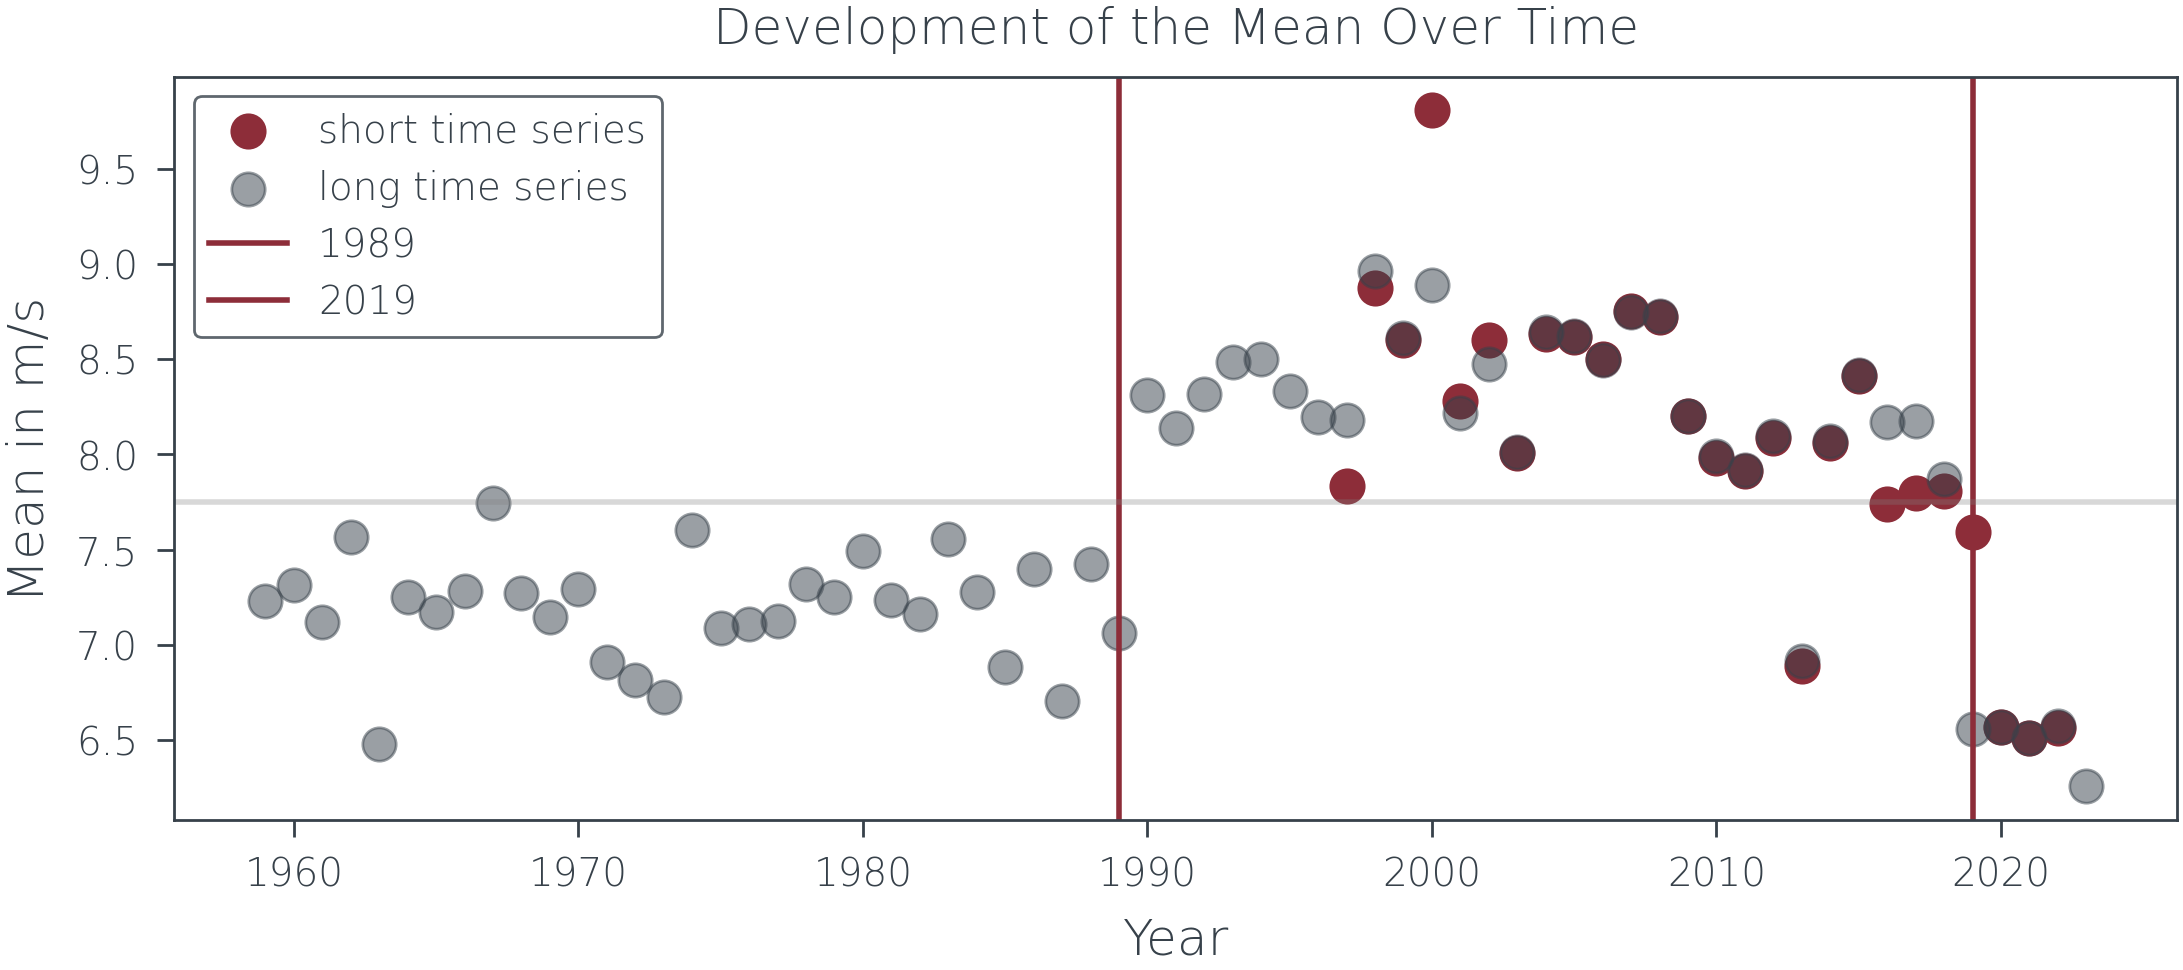

In [21]:

import scipy

# plot the mean per year

X=df['FF_10_wind']
X=df[ (df['FF_10_wind']>0) & ~np.isnan(df['FF_10_wind'])]
yearly_df['Mean']=0.0
for y in yearly_df.index:
    yearly_df.loc[y, 'Mean']=X[X['MESS_DATUM'].dt.year==y]['FF_10_wind'].mean() 

plt.scatter(yearly_df.index,  yearly_df['Mean'] , label='short time series',alpha=1)
plt.scatter(mean_df.index, mean_df,  label='long time series', alpha=0.5)
plt.axvline(x=1989, label="1989")
plt.axvline(x=2019, label='2019')
plt.axhline(y=7.75, color='gray', alpha=0.3)
plt.title('Development of the Mean Over Time' )
plt.ylabel('Mean in m/s')
plt.xlabel('Year')
plt.legend()
plt.show()




In [22]:
early_df.set_index('DATE', inplace=True)
from datetime import datetime
early_df['FF']=-999
X=df['FF_10_wind']
X=df[ (df['FF_10_wind']>0) & ~np.isnan(df['FF_10_wind'])]
'''
for date in early_df.index:
    print(pd.to_datetime(date).strftime('%Y-%m-%d'))
    
    if y < 1997:
        continue
    Y= X[ (X['MESS_DATUM'].dt.date== date.date()) ]['FF_10_wind']
    if len(Y)>0:
       mean=Y.mean()
       print(mean)
       early_df.loc[str(date), 'FF']=mean

early_df

'''

"\nfor date in early_df.index:\n    print(pd.to_datetime(date).strftime('%Y-%m-%d'))\n    \n    if y < 1997:\n        continue\n    Y= X[ (X['MESS_DATUM'].dt.date== date.date()) ]['FF_10_wind']\n    if len(Y)>0:\n       mean=Y.mean()\n       print(mean)\n       early_df.loc[str(date), 'FF']=mean\n\nearly_df\n\n"

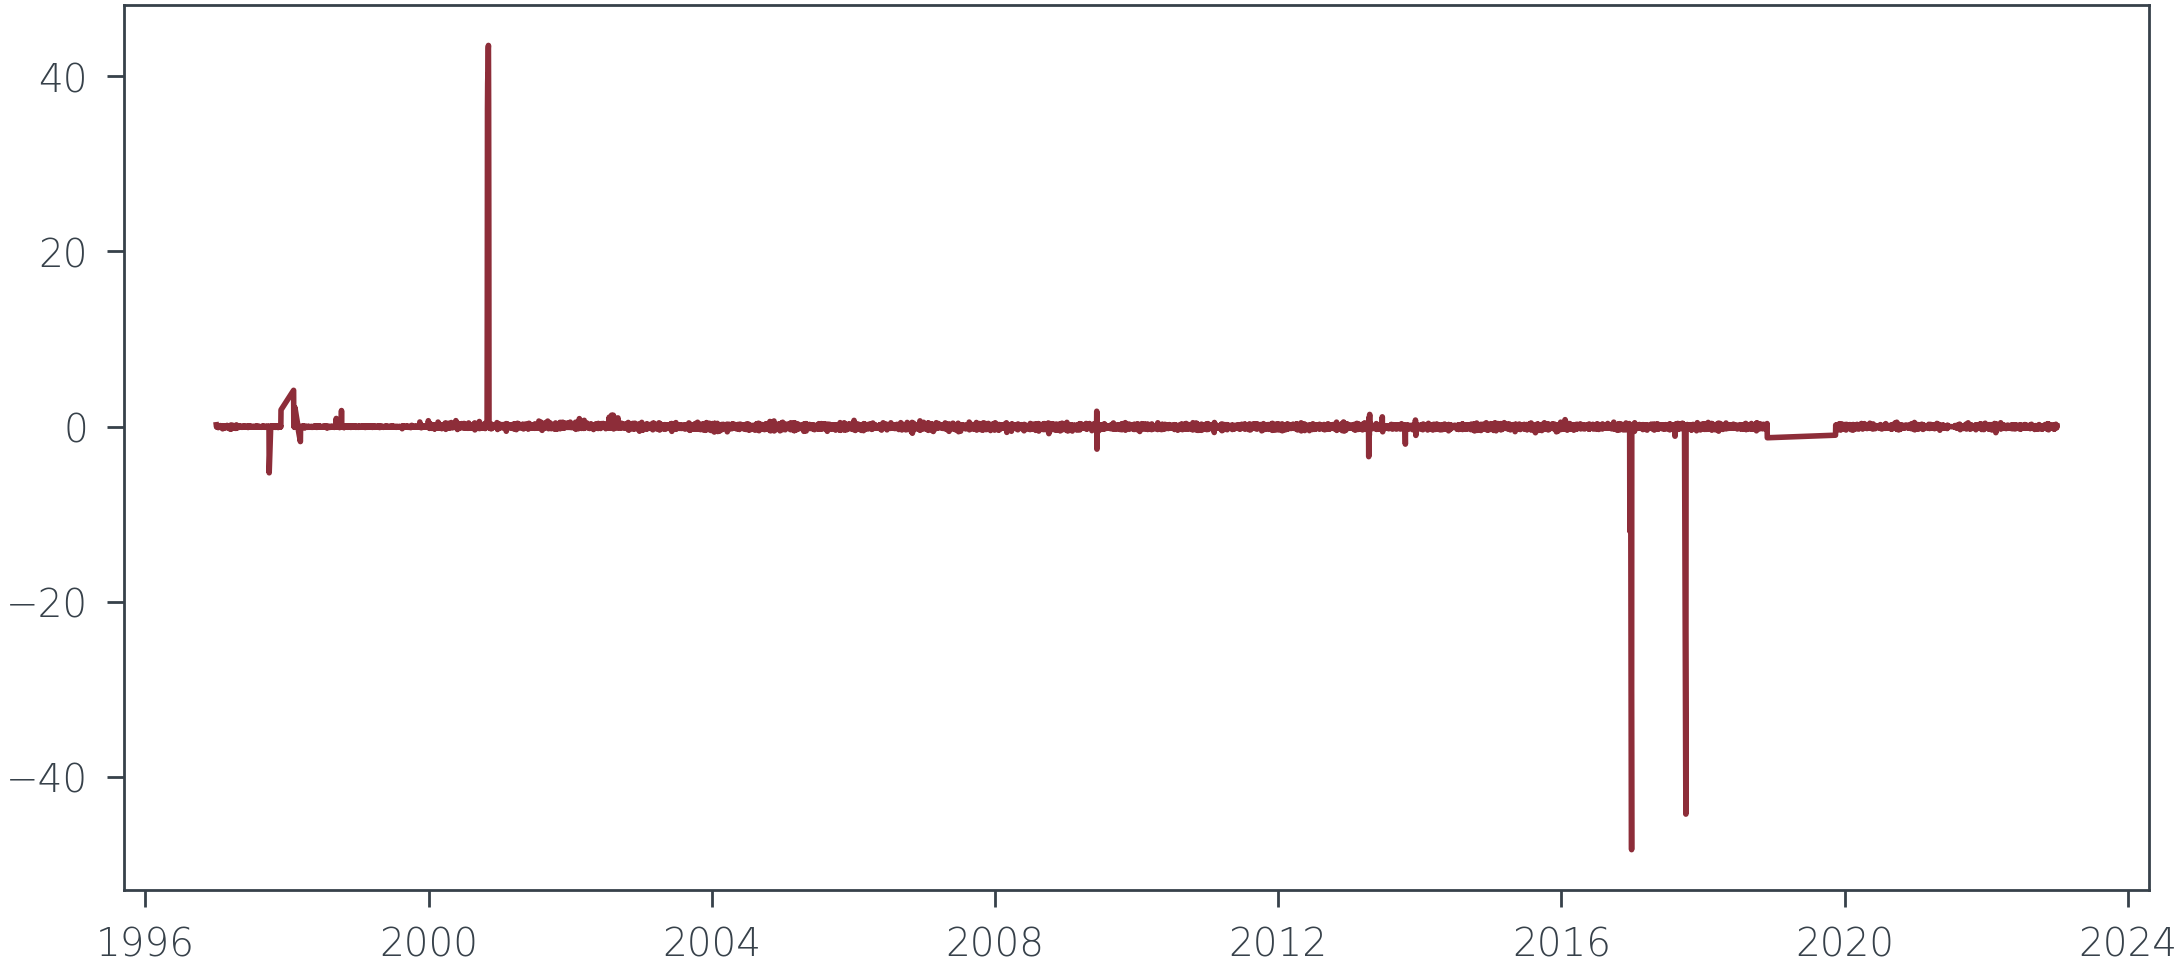

0.15729184623854164
106
0.011793502447708056


In [23]:

# Filter X based on the condition for all dates in early_df.index at once
filtered_X = X[(X['MESS_DATUM'].dt.year >= 1997) & X['MESS_DATUM'].dt.date.isin(early_df.index.date)]

# Calculate mean values for each date
mean_values = filtered_X.groupby(filtered_X['MESS_DATUM'].dt.date)['FF_10_wind'].mean()

# Update early_df with the calculated means
early_df['FF'] = early_df.index.date
early_df['FF'] = early_df['FF'].map(mean_values)
# Print early_df with means
mask=(~ np.isnan(early_df['FF'])) & (early_df['FG']>0) 
plt.plot(early_df[mask].index, early_df[mask]['FF'] -early_df[mask]['FG'] )
plt.show()
diff=early_df[mask]['FF'] -early_df[mask]['FG']
s=(diff[(diff <1/2) & (diff >-1/2)]).std()
print(s)
len(diff[~((diff <1/2) & (diff >-1/2))])
print(len(diff[~((diff <1/2) & (diff >-1/2))]))
print(len(diff[~((diff <1/2) & (diff >-1/2))])/len(diff))


In [24]:
ds=0
for d in range (1, 31):
   ds=ds+df[ (df['MESS_DATUM'].dt.date==datetime(2002, 1, d).date() )]['FF_10_wind'].std()
print(ds/30)

1.8092349166478565


In [25]:
def yearly_mean_params(first: int, last: int, dataframe: pd.DataFrame) -> pd.DataFrame:
    '''
    Returns a dataframe that has the parameters (estimated mit the MLE) for all the years in the intervall [start,end], 
    based on the dataframe that contains all our data
    '''

    # initialize a dataframe that has the years as indices
    yearly_df=pd.DataFrame()
    yearly_df['Years']=np.arange(first, last+1)
    yearly_df['param_lambda']=0.0
    yearly_df['param_beta']=0.0
    yearly_df.set_index('Years', inplace=True)

    # compute the parameters for each year
    for y in yearly_df.index:
        mask=dataframe.index.year == y
        weibull=Weibull.estimate(dataframe[mask]['FG'])
        yearly_df.loc[y, 'param_lambda' ]=weibull.lambd
        yearly_df.loc[y, 'param_beta' ]=weibull.beta

    return yearly_df

mean_yearly_df=yearly_mean_params(1997,2022, early_df)



In [26]:
'''
plt.scatter(yearly_df.index, yearly_df['param_lambda'], label='parameter lambda' )
plt.scatter(yearly_df.index, yearly_df['param_beta'], label='parameter beta' )
plt.scatter(mean_yearly_df.index, mean_yearly_df['param_lambda']+0.057, label='parameter lambda meanbased + 0.057' )
plt.scatter(mean_yearly_df.index, mean_yearly_df['param_beta']-0.385, label='parameter beta meanbased -0.385' )
plt.title('Developement of the Estimated Weibull-Parameters over Time')
plt.xlabel('Year')
plt.ylabel('Value')
plt.legend()
plt.show()

print((yearly_df['param_lambda']-mean_yearly_df['param_lambda'] ).mean())
print((yearly_df['param_beta']-mean_yearly_df['param_beta'] ).mean())


print((yearly_df['param_lambda']-mean_yearly_df['param_lambda'] ).std())

print((yearly_df['param_beta']-mean_yearly_df['param_beta'] ).std())

'''


"\nplt.scatter(yearly_df.index, yearly_df['param_lambda'], label='parameter lambda' )\nplt.scatter(yearly_df.index, yearly_df['param_beta'], label='parameter beta' )\nplt.scatter(mean_yearly_df.index, mean_yearly_df['param_lambda']+0.057, label='parameter lambda meanbased + 0.057' )\nplt.scatter(mean_yearly_df.index, mean_yearly_df['param_beta']-0.385, label='parameter beta meanbased -0.385' )\nplt.title('Developement of the Estimated Weibull-Parameters over Time')\nplt.xlabel('Year')\nplt.ylabel('Value')\nplt.legend()\nplt.show()\n\nprint((yearly_df['param_lambda']-mean_yearly_df['param_lambda'] ).mean())\nprint((yearly_df['param_beta']-mean_yearly_df['param_beta'] ).mean())\n\n\nprint((yearly_df['param_lambda']-mean_yearly_df['param_lambda'] ).std())\n\nprint((yearly_df['param_beta']-mean_yearly_df['param_beta'] ).std())\n\n"

number of bins for fitting is 23
number of bins for fitting is 23
number of bins for fitting is 23
number of bins for fitting is 23
number of bins for fitting is 22
number of bins for fitting is 22
number of bins for fitting is 22
number of bins for fitting is 22
number of bins for fitting is 24
number of bins for fitting is 24
number of bins for fitting is 24
number of bins for fitting is 24
number of bins for fitting is 24
number of bins for fitting is 24
number of bins for fitting is 24
number of bins for fitting is 24
number of bins for fitting is 24
number of bins for fitting is 24
number of bins for fitting is 24
number of bins for fitting is 24
number of bins for fitting is 24
number of bins for fitting is 24
number of bins for fitting is 24
number of bins for fitting is 24
number of bins for fitting is 24
number of bins for fitting is 24
number of bins for fitting is 24
number of bins for fitting is 24
number of bins for fitting is 24
number of bins for fitting is 24
number of 

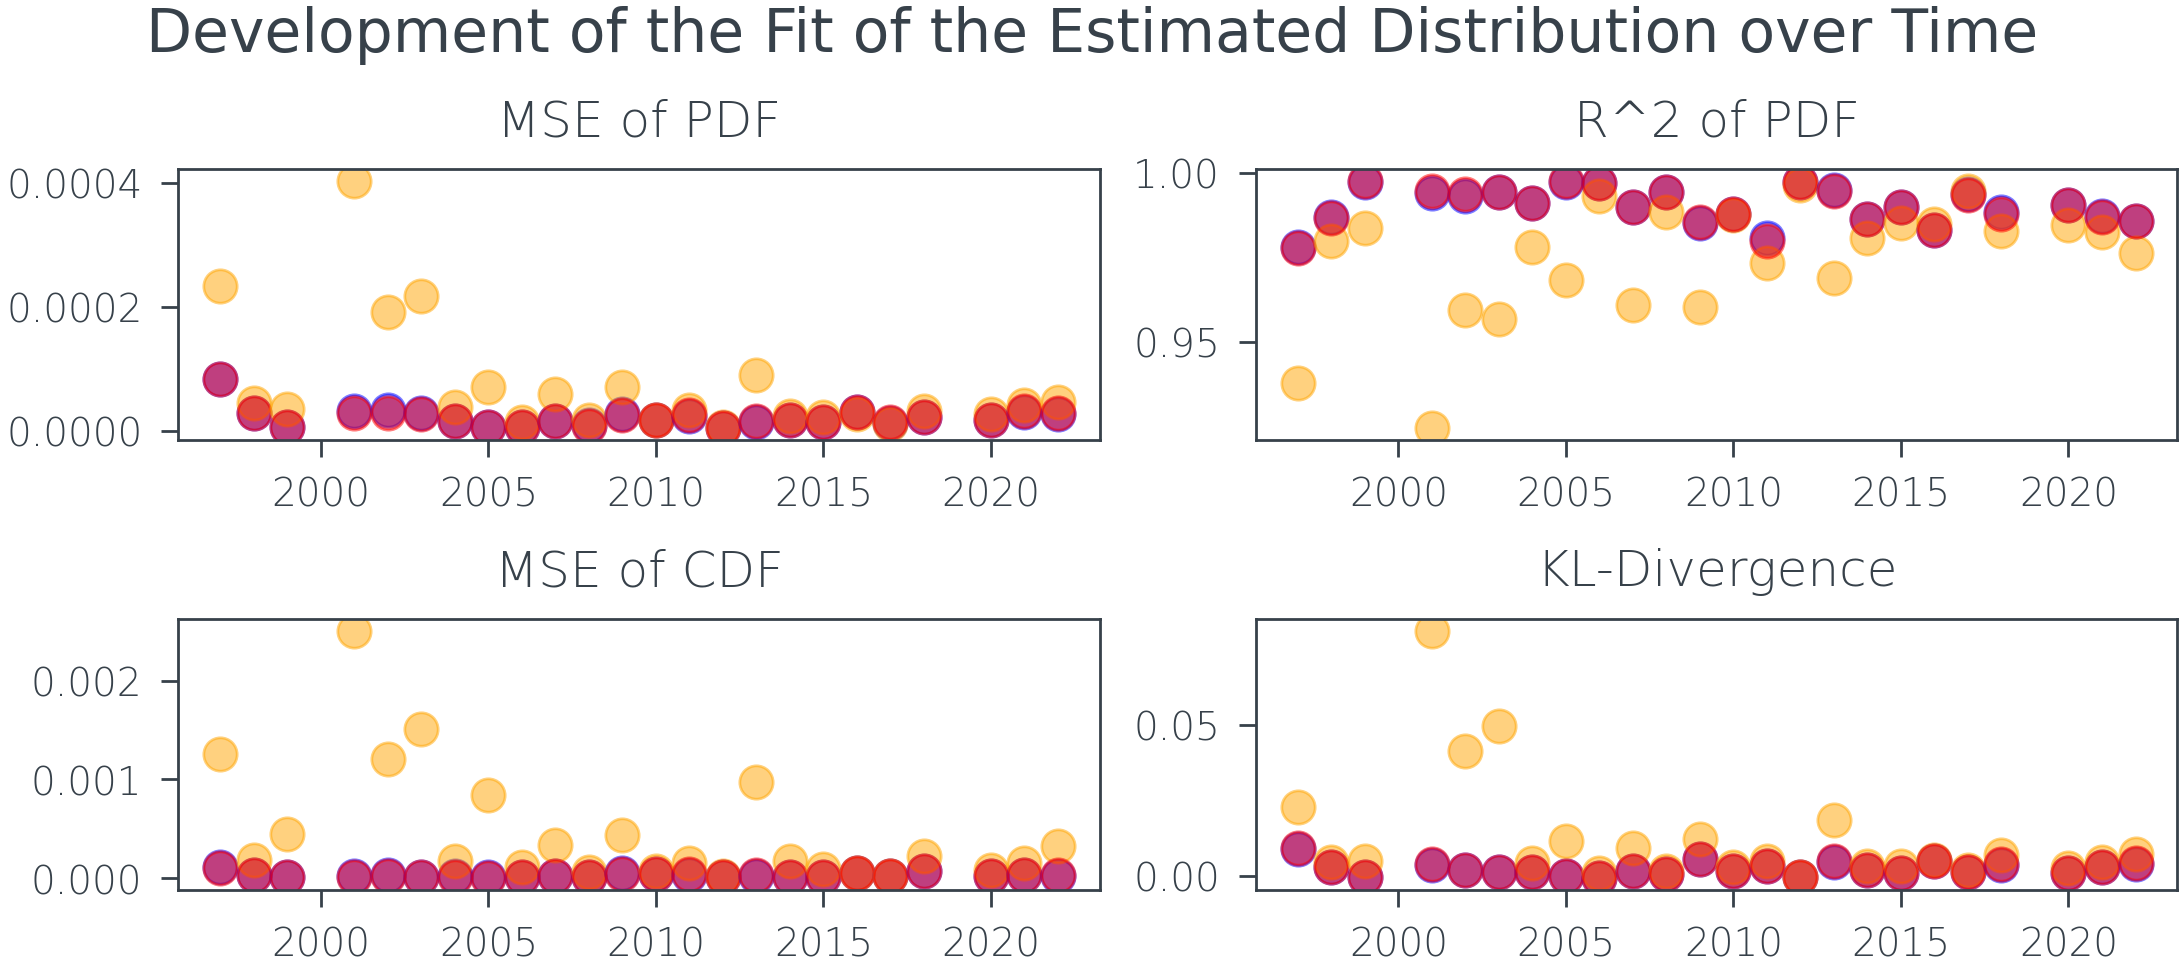

In [27]:
# how does the goodness of fit develop over time (yearly)?

figure, axis = plt.subplots(2, 2)

for y in range(1997, 2023):
    if y==2000 or y==2019:
        continue
    mle_weibull=Weibull.estimate(df[(df['MESS_DATUM'].dt.year == y)]["FF_10_wind"])
    graphical_weibull=Weibull.graphical_estimate(df[(df['MESS_DATUM'].dt.year == y)]["FF_10_wind"])
    epf_weibull=Weibull.epf_estimate(df[(df['MESS_DATUM'].dt.year == y)]["FF_10_wind"])
    #mean_weibull=Weibull(mean_yearly_df.loc[y, ['param_lambda']].item(), mean_yearly_df.loc[y, ['param_beta']].item())#
    mean_weibull=Weibull.estimate(early_df[early_df.index.year==y]['FG'])
    
    fit1= mle_weibull.fit(df[(df['MESS_DATUM'].dt.year == y)]["FF_10_wind"])
    fit2=graphical_weibull.fit(df[(df['MESS_DATUM'].dt.year == y)]["FF_10_wind"])
    fit3=epf_weibull.fit(df[(df['MESS_DATUM'].dt.year == y)]["FF_10_wind"])
    fit4=mean_weibull.fit(df[(df['MESS_DATUM'].dt.year == y)]["FF_10_wind"])


    axis[0,0].scatter(y,fit1[0], color='blue', alpha=0.5 , label='MLM') 
    axis[0,0].scatter(y, fit2[0], color='orange', alpha=0.5, label='graphical method')
    axis[0,0].scatter(y, fit3[0], color='red', alpha=0.5, label='epf method')
    #axis[0,0].scatter(y, fit4[0], color='green', alpha=0.5, label='mean method')
    axis[0, 0].set_title("MSE of PDF")

    axis[1,0].scatter(y, fit1[1], color='blue', alpha=0.5) 
    axis[1,0].scatter(y, fit2[1], color='orange', alpha=0.5)
    axis[1,0].scatter(y, fit3[1], color='red', alpha=0.5)
    
    #axis[1,0].scatter(y, fit4[1], color='green', alpha=0.5)
    
    axis[1, 0].set_title("MSE of CDF")

    axis[0,1].scatter(y, fit1[2], color='blue', alpha=0.5) 
    axis[0,1].scatter(y, fit2[2], color='orange', alpha=0.5)
    axis[0,1].scatter(y, fit3[2], color='red', alpha=0.5)
    
    #axis[0,1].scatter(y, fit4[2], color='green', alpha=0.5)
    axis[0, 1].set_title("R^2 of PDF")

    axis[1,1].scatter(y, fit1[4], color='blue', alpha=0.5) 
    axis[1,1].scatter(y, fit2[4], color='orange', alpha=0.5)
    axis[1,1].scatter(y, fit3[4], color='red', alpha=0.5)
    
    #axis[1,1].scatter(y, fit4[4], color='green', alpha=0.5)
    axis[1, 1].set_title("KL-Divergence")

figure.suptitle('Development of the Fit of the Estimated Distribution over Time')
#plt.xlabel('Year')
#plt.ylabel('Fit')
#plt.legend()
plt.show()

number of bins for fitting is 8
number of bins for fitting is 8
number of bins for fitting is 8
number of bins for fitting is 8
number of bins for fitting is 8
number of bins for fitting is 8
number of bins for fitting is 8
number of bins for fitting is 8
number of bins for fitting is 8
number of bins for fitting is 8
number of bins for fitting is 8
number of bins for fitting is 8
number of bins for fitting is 8
number of bins for fitting is 8
number of bins for fitting is 8
number of bins for fitting is 8
number of bins for fitting is 8
number of bins for fitting is 8
number of bins for fitting is 8
number of bins for fitting is 8
number of bins for fitting is 8
number of bins for fitting is 8
number of bins for fitting is 8
number of bins for fitting is 8
number of bins for fitting is 8
number of bins for fitting is 8
number of bins for fitting is 8
number of bins for fitting is 8
number of bins for fitting is 8
number of bins for fitting is 8
number of bins for fitting is 8
number o

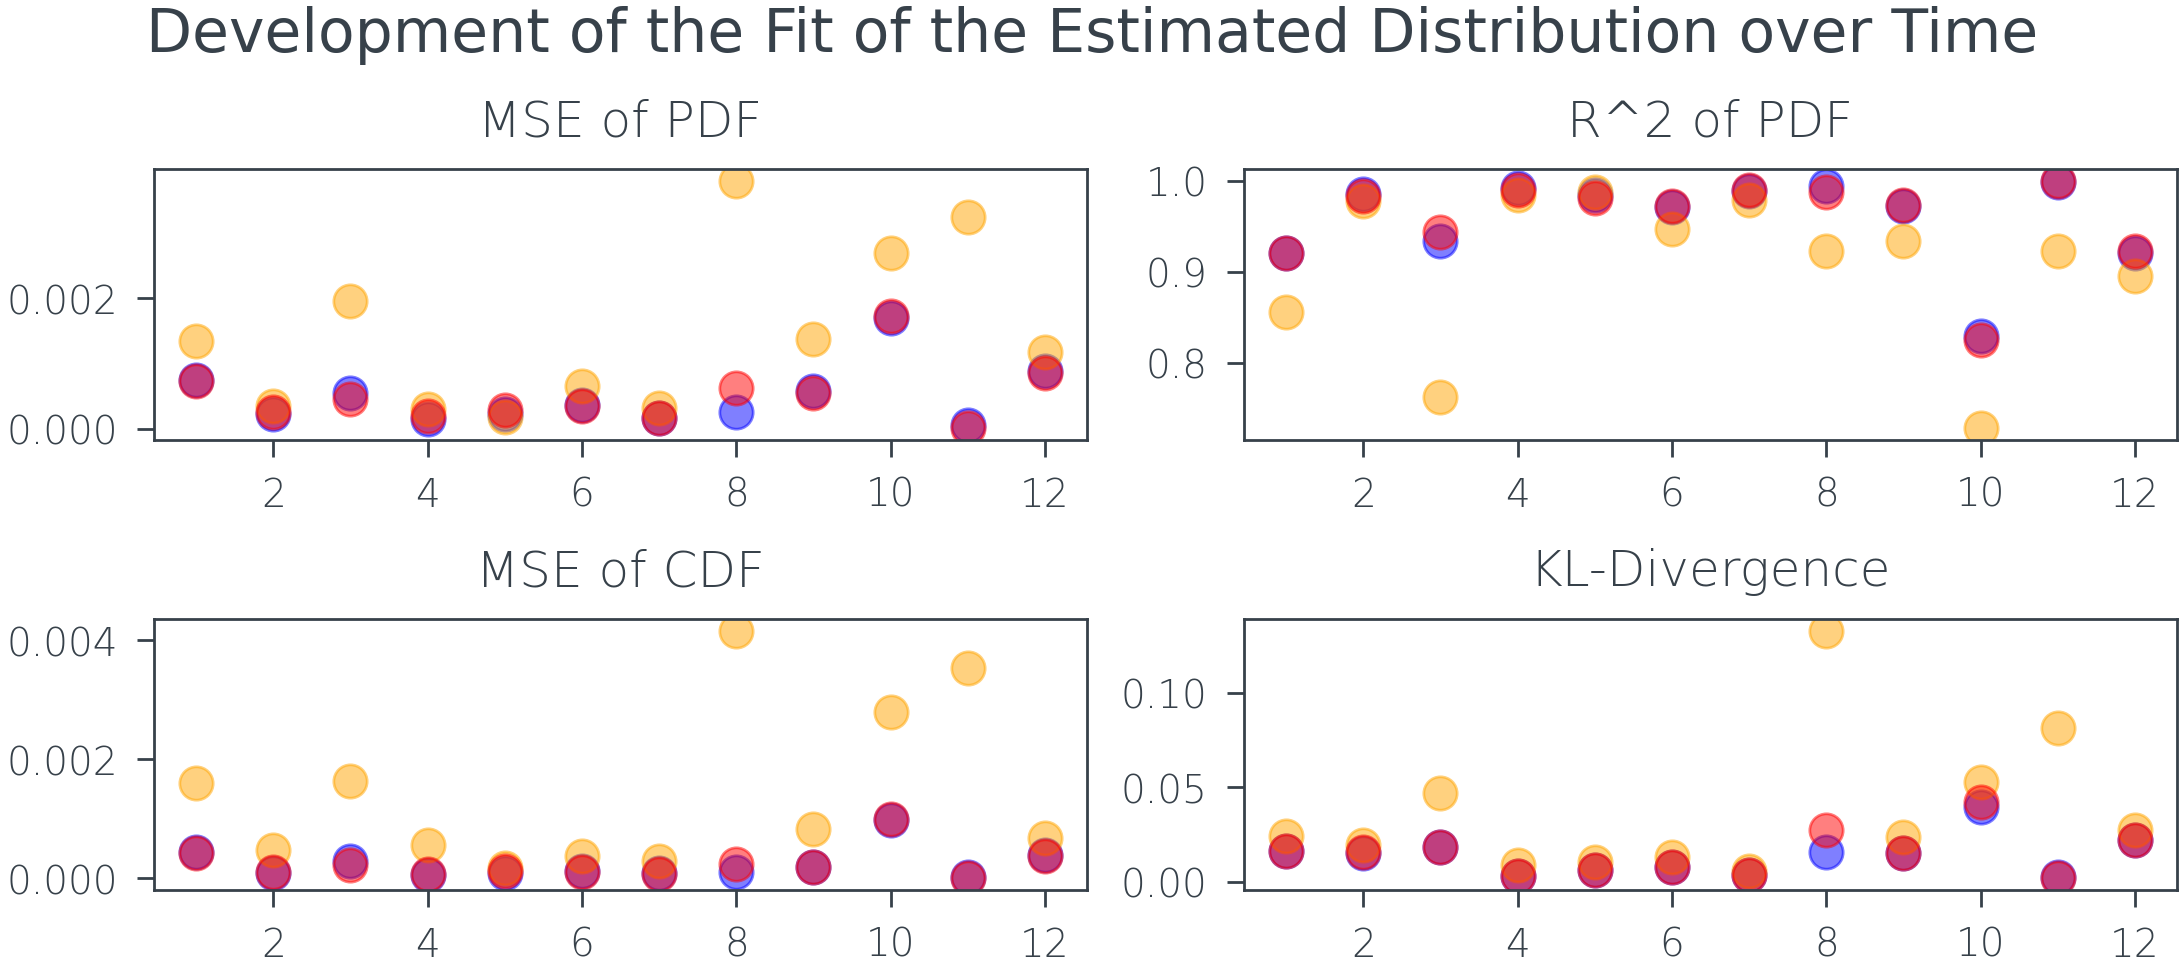

In [28]:
# how does the goodness of fit develop over time (monthly)?

figure, axis = plt.subplots(2, 2)

for m in range(1,13):
    mask=(df['MESS_DATUM'].dt.year == 2001) & (df['MESS_DATUM'].dt.month == m) 
    mask2=(early_df.index.year == 2001)&(early_df.index.month == m)
    mle_weibull=Weibull.estimate(df[mask]["FF_10_wind"])
    graphical_weibull=Weibull.graphical_estimate(df[mask]["FF_10_wind"])
    epf_weibull=Weibull.epf_estimate(df[mask]["FF_10_wind"])

    mean_weibull=Weibull.estimate(early_df[mask2]['FG'])

    
    fit1= mle_weibull.fit(df[mask]["FF_10_wind"])
    fit2=graphical_weibull.fit(df[mask]["FF_10_wind"])
    fit3=epf_weibull.fit(df[mask]["FF_10_wind"])
    fit4=mean_weibull.fit(df[mask]["FF_10_wind"])


    axis[0,0].scatter(m,fit1[0], color='blue', alpha=0.5 , label='MLM') 
    axis[0,0].scatter(m, fit2[0], color='orange', alpha=0.5, label='graphical method')
    axis[0,0].scatter(m, fit3[0], color='red', alpha=0.5, label='epf method')
    #axis[0,0].scatter(m, fit4[0], color='green', alpha=0.5, label='mean method')
    axis[0, 0].set_title("MSE of PDF")

    axis[1,0].scatter(m, fit1[1], color='blue', alpha=0.5) 
    axis[1,0].scatter(m, fit2[1], color='orange', alpha=0.5)
    axis[1,0].scatter(m, fit3[1], color='red', alpha=0.5)
    #axis[1,0].scatter(m, fit4[1], color='green', alpha=0.5)
    
    axis[1, 0].set_title("MSE of CDF")

    axis[0,1].scatter(m, fit1[2], color='blue', alpha=0.5) 
    axis[0,1].scatter(m, fit2[2], color='orange', alpha=0.5)
    axis[0,1].scatter(m, fit3[2], color='red', alpha=0.5)
    
    #axis[0,1].scatter(m, fit4[2], color='green', alpha=0.5)
    axis[0, 1].set_title("R^2 of PDF")

    axis[1,1].scatter(m, fit1[4], color='blue', alpha=0.5) 
    axis[1,1].scatter(m, fit2[4], color='orange', alpha=0.5)
    axis[1,1].scatter(m, fit3[4], color='red', alpha=0.5)
    
    #axis[1,1].scatter(m, fit4[4], color='green', alpha=0.5)
    axis[1, 1].set_title("KL-Divergence")

figure.suptitle('Development of the Fit of the Estimated Distribution over Time')
#plt.xlabel('Year')
#plt.ylabel('Fit')
#plt.legend()
plt.show()

       param_lambda  param_beta      Mean
Years                                    
1997       8.861604    2.087072  7.833067
1998      10.005246    2.407249  8.871647
1999       9.720176    2.258058  8.601877
2000      10.025728    2.328218  9.806298
2001       9.349950    2.333289  8.278247
2002       9.718859    2.173627  8.599438
2003       9.038749    2.356487  8.004308
2004       9.750623    2.317239  8.632244
2005       9.730091    2.345312  8.615464
2006       9.597722    2.300996  8.499817
2007       9.885387    2.311233  8.749993
2008       9.844887    2.348879  8.719922
2009       9.261068    2.369338  8.198804
2010       9.014339    2.218108  7.980112
2011       8.931837    2.234137  7.909726
2012       9.114825    2.432221  8.086451
2013       7.787341    2.166270  6.889027
2014       9.095725    2.291827  8.059437
2015       9.498329    2.313456  8.412474
2016       8.730700    2.259663  7.736398
2017       8.798438    2.279719  7.795856
2018       8.821289    2.202629  7

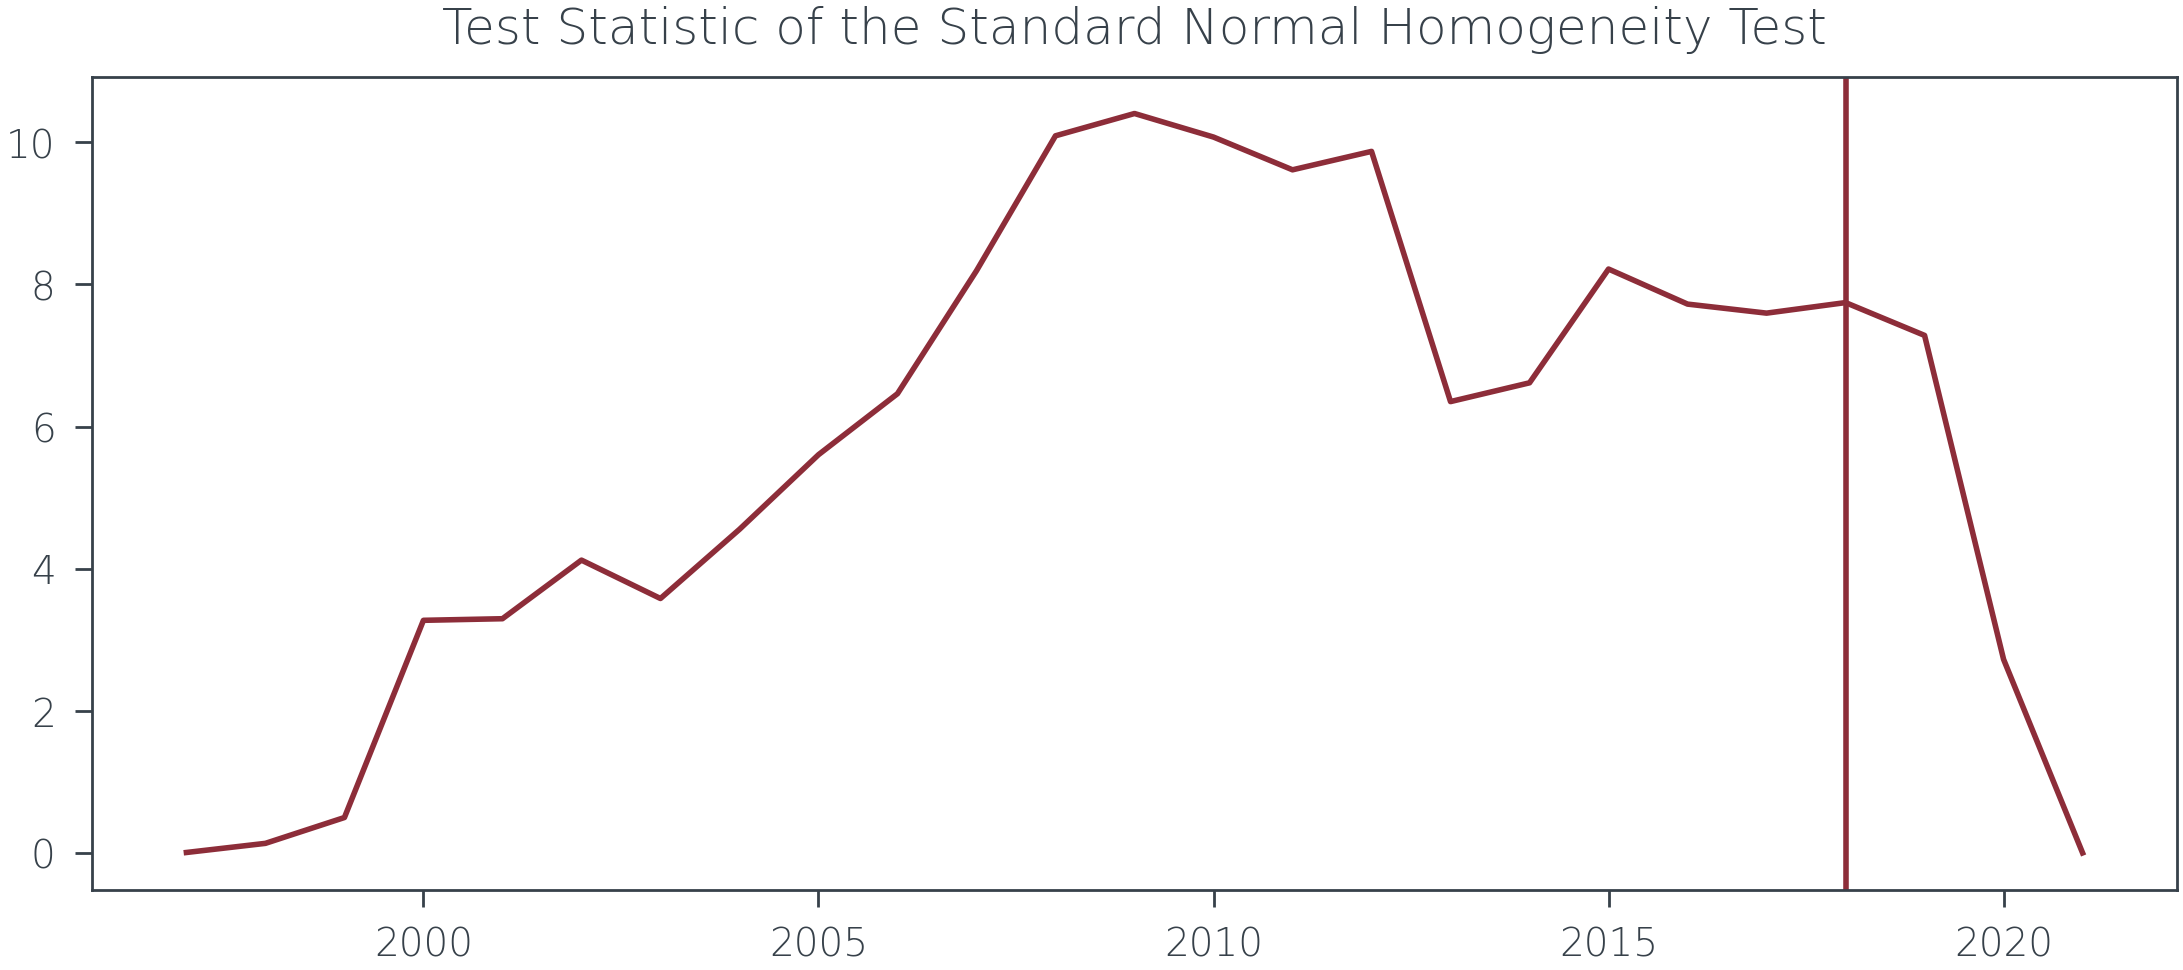

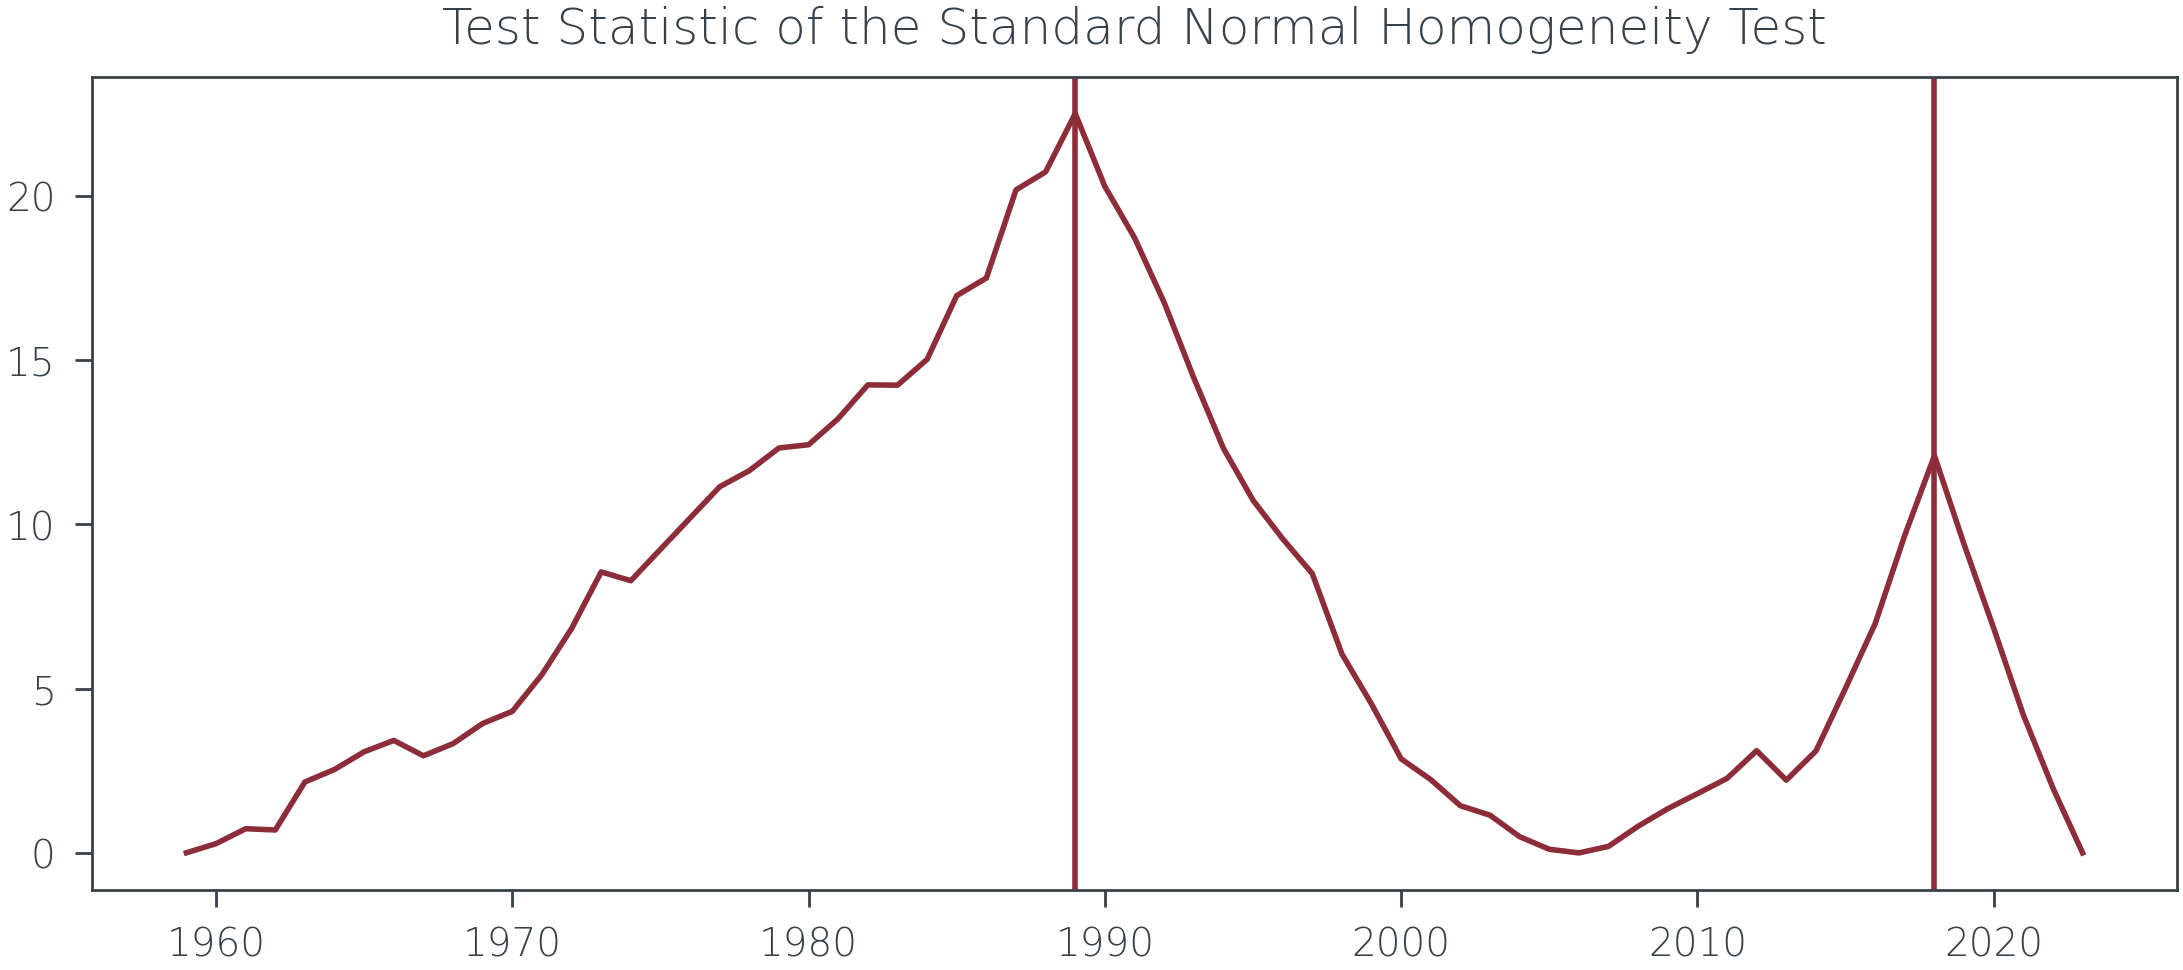

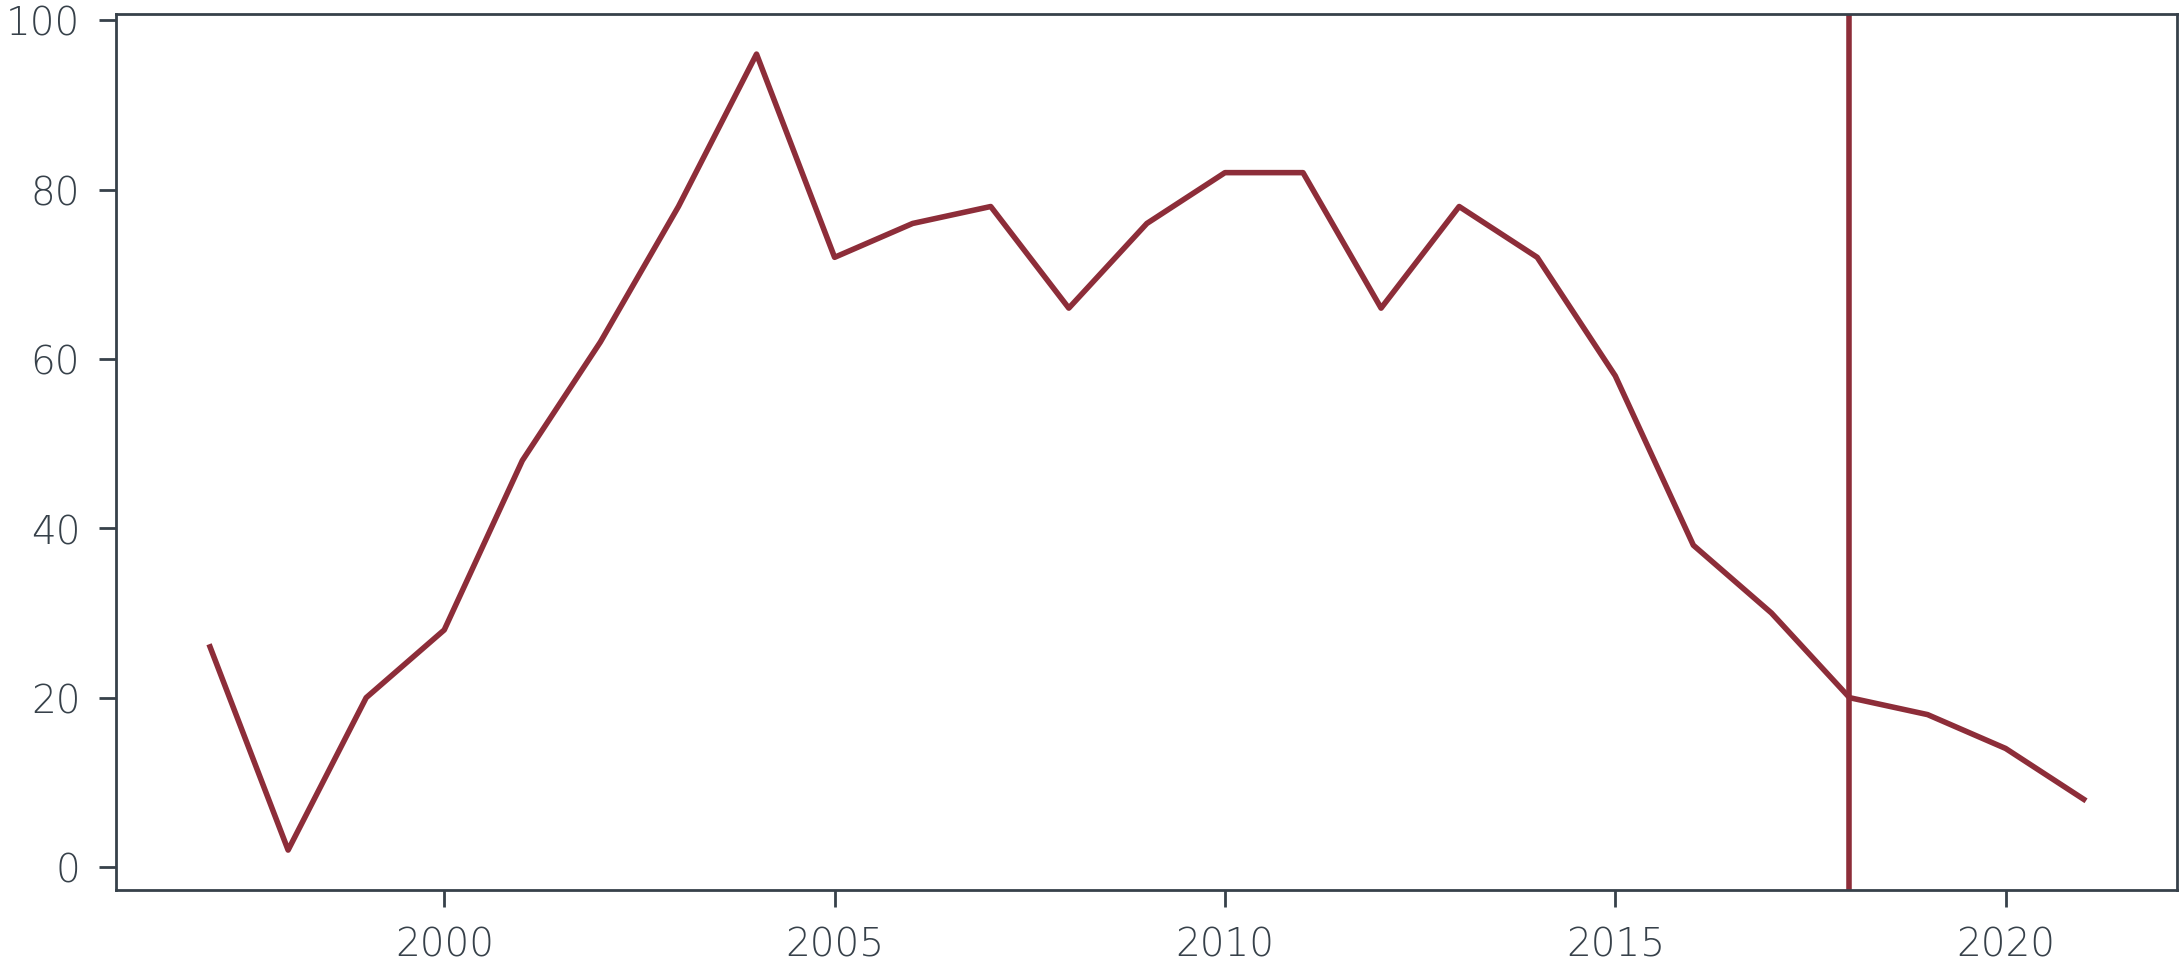

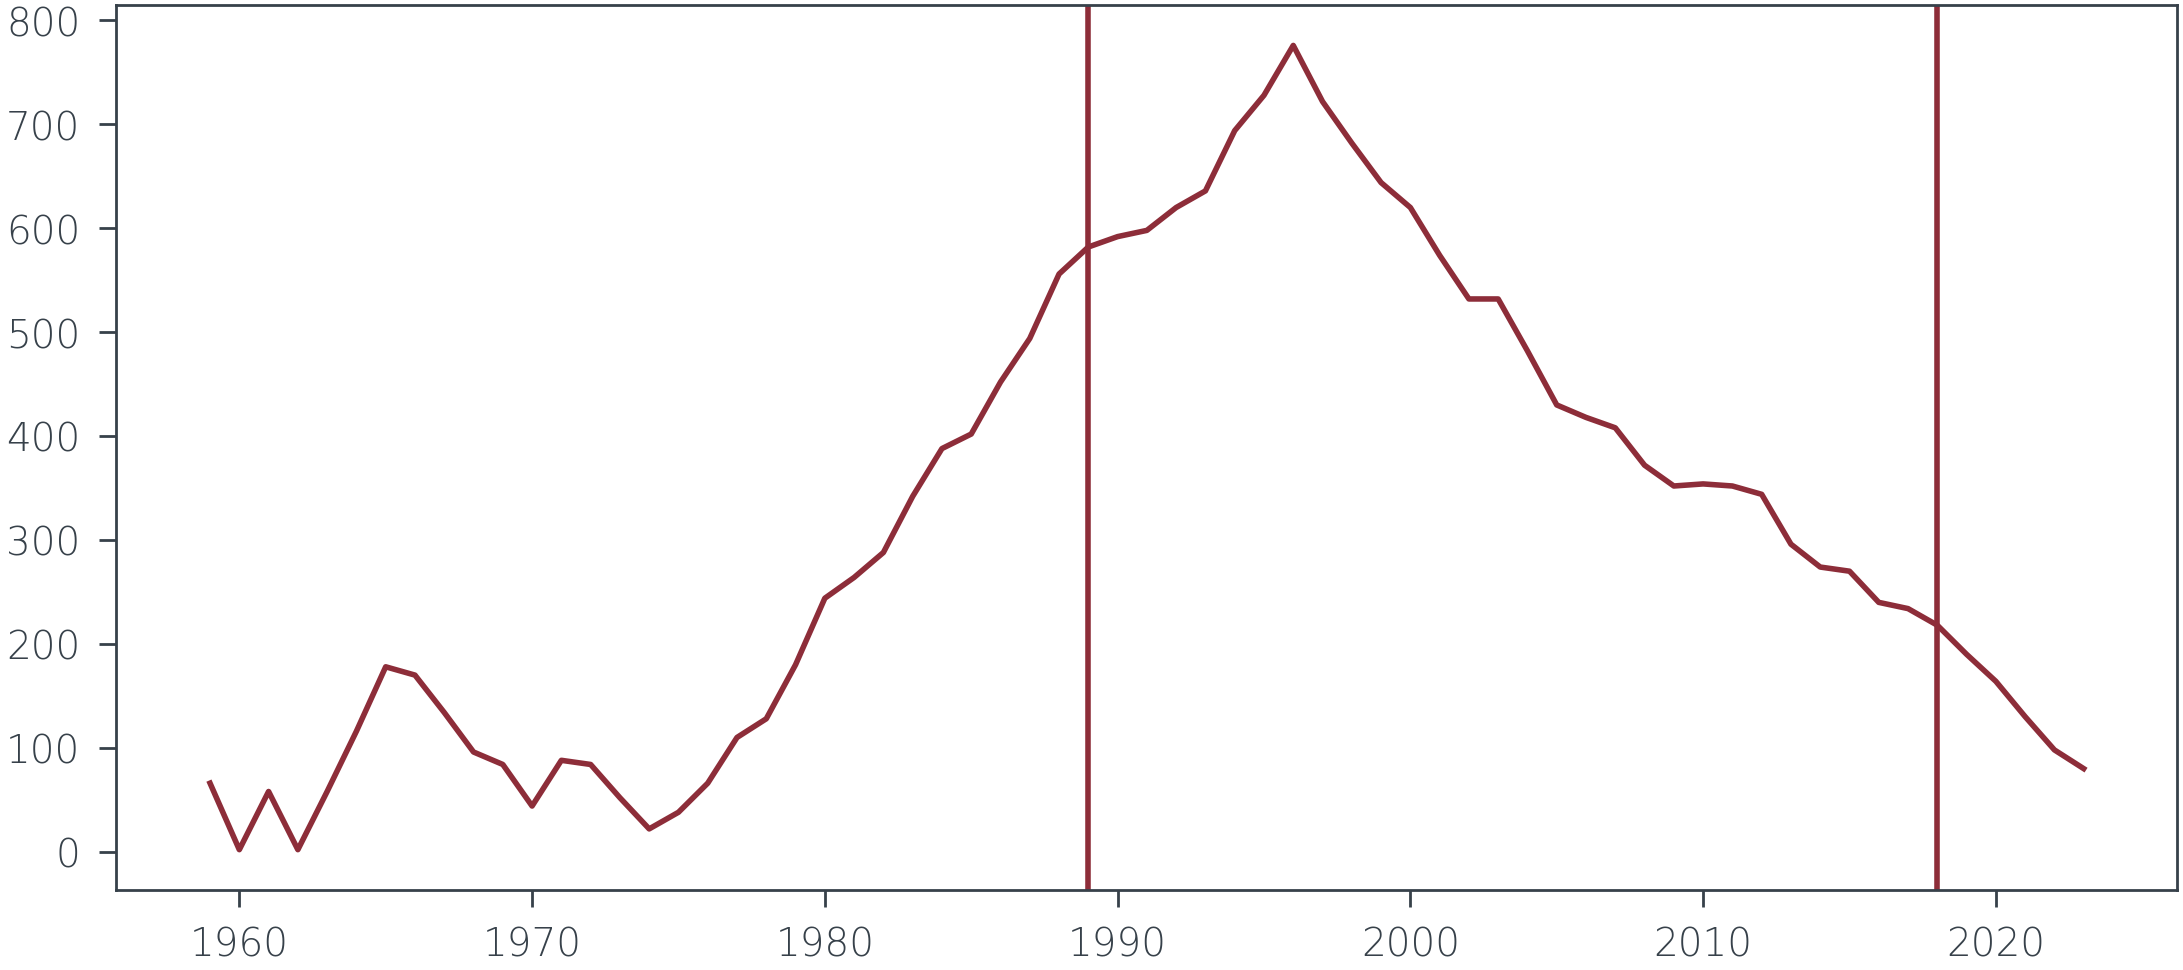

In [29]:
from get_params import snh_test
from get_params import pettitt_test

print(yearly_df)
reduced=pd.DataFrame(yearly_df, index=range(1997, 2022))
plt.plot( reduced.index, snh_test(reduced['Mean']))

plt.axvline(x=2018)
plt.title('Test Statistic of the Standard Normal Homogeneity Test')
plt.show()

plt.plot(mean_df.index, snh_test(mean_df['Mean']))

plt.title('Test Statistic of the Standard Normal Homogeneity Test')
plt.axvline(x=1989)
plt.axvline(x=2018)
plt.show()



plt.plot( reduced.index, pettitt_test(reduced['Mean']))

plt.axvline(x=2018)
plt.show()

plt.plot(mean_df.index, pettitt_test(mean_df['Mean']))
plt.axvline(x=1989)
plt.axvline(x=2018)
plt.show()

In [30]:
import pyhomogeneity as hg

print(hg.pettitt_test(yearly_df['param_lambda']))


ModuleNotFoundError: No module named 'pyhomogeneity'

[ 6.35900537 15.4762478   1.85714279 14.88099999]


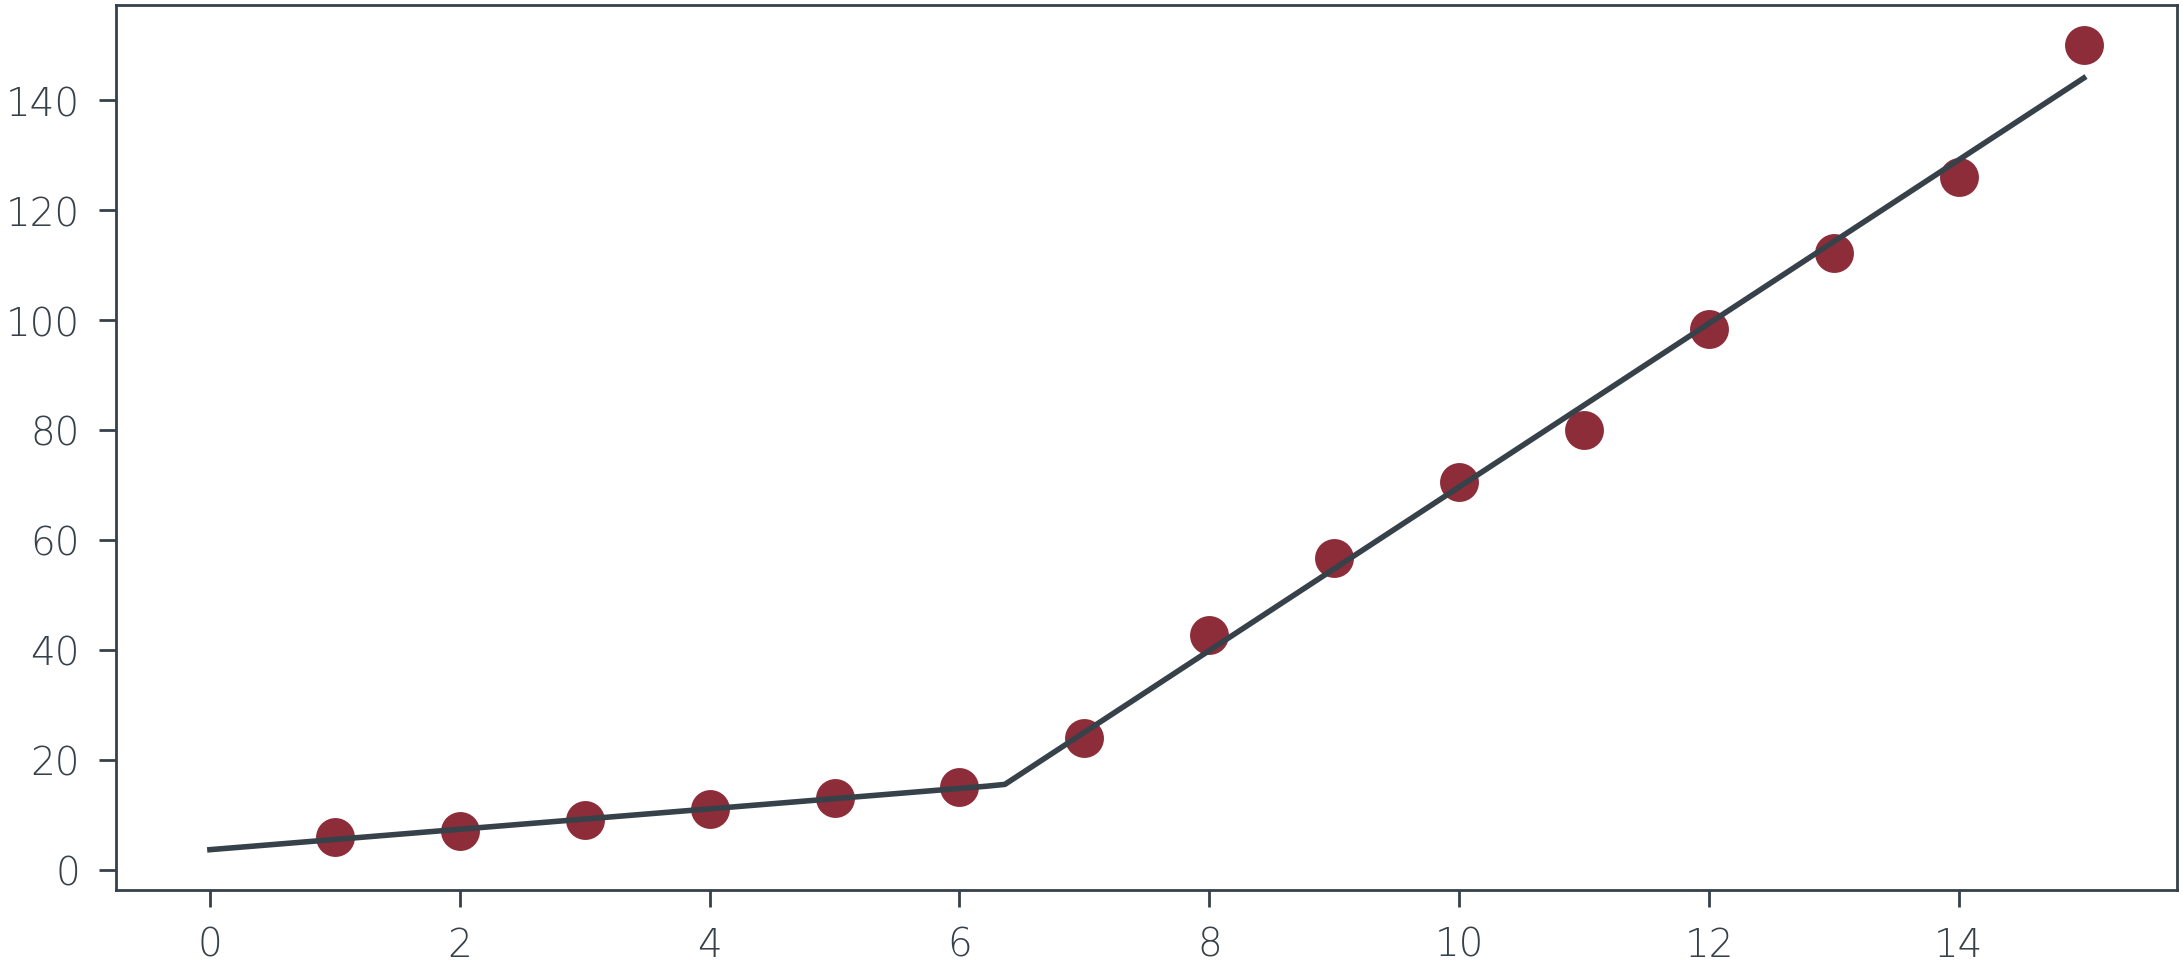

In [ ]:
from scipy import optimize
x = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10 ,11, 12, 13, 14, 15], dtype=float)
y = np.array([6, 7, 9, 11, 13, 15, 24, 42.81, 56.7, 70.59,80, 98.36, 112.25, 126.14, 150])

def piecewise_linear(x, x0, y0, k1, k2):
    return np.piecewise(x, [x < x0], [lambda x:k1*x + y0-k1*x0, lambda x:k2*x + y0-k2*x0])

p , e = optimize.curve_fit(piecewise_linear, x, y)
xd = np.linspace(0, 15, 100)
plt.plot(x, y, "o")
plt.plot(xd, piecewise_linear(xd, *p))
print(p)

C:\Users\gwend\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


[1.00002981 1.         1.         1.        ]


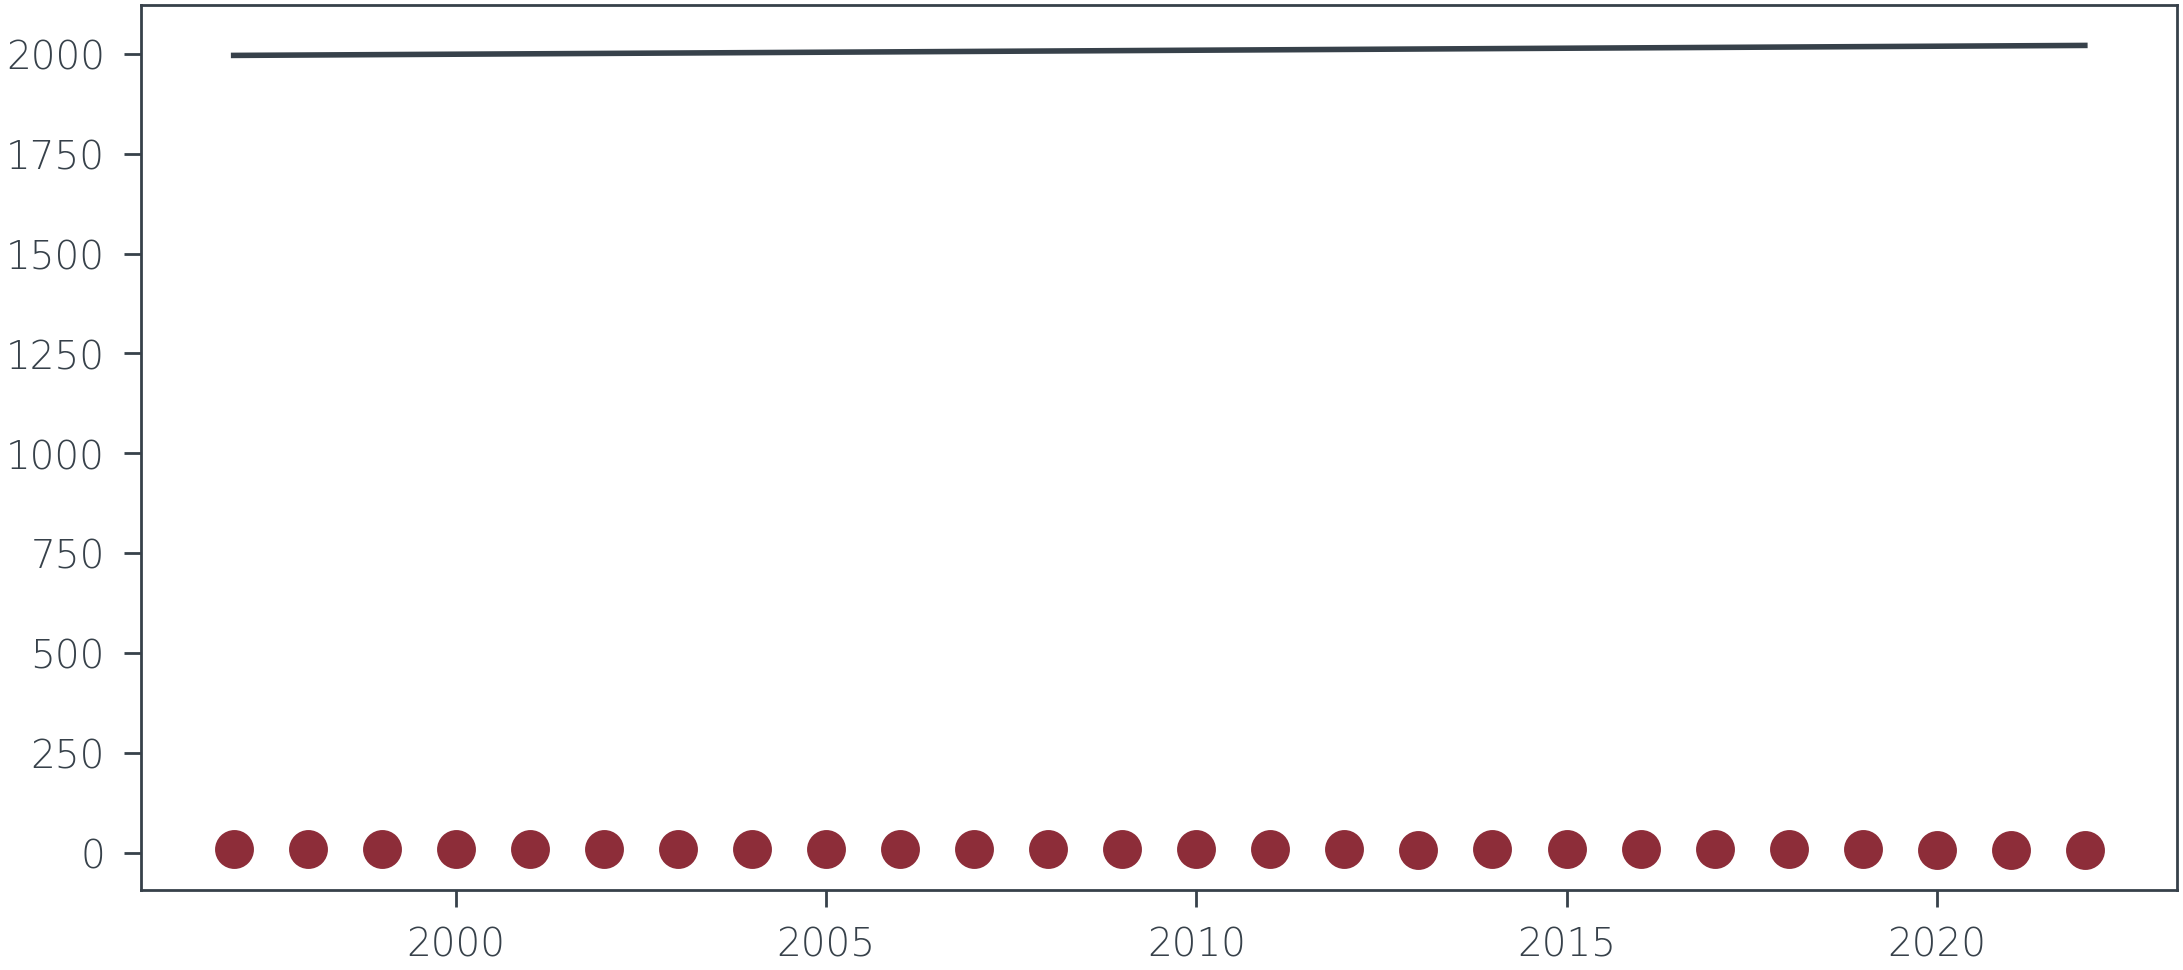

In [ ]:
x = yearly_df.index
y = yearly_df['param_lambda']

def piecewise_linear(x, x0, y0, k1, k2):
    return np.piecewise(x, [x < x0], [lambda x:k1*x + y0-k1*x0, lambda x:k2*x + y0-k2*x0])

p , e = optimize.curve_fit(piecewise_linear, x, y)
xd = np.linspace(1990,2022, 30 )
plt.plot(x, y, "o")
plt.plot(x, piecewise_linear(x, *p))
print(p)


In [ ]:
def segments_fit(X, Y, count):
    xmin = X.min()
    xmax = X.max()

    seg = np.full(count - 1, (xmax - xmin) / count)

    px_init = np.r_[np.r_[xmin, seg].cumsum(), xmax]
    py_init = np.array([Y[np.abs(X - x) < 3].mean() for x in px_init])

    def func(p):
        seg = p[:count - 1]
        py = p[count - 1:]
        px = np.r_[np.r_[xmin, seg].cumsum(), xmax]
        return px, py

    def err(p):
        px, py = func(p)
        Y2 = np.interp(X, px, py)
        return np.mean((Y - Y2)**2)

    r = optimize.minimize(err, x0=np.r_[seg, py_init], method='Nelder-Mead')
    return func(r.x)

0.4142151022946373


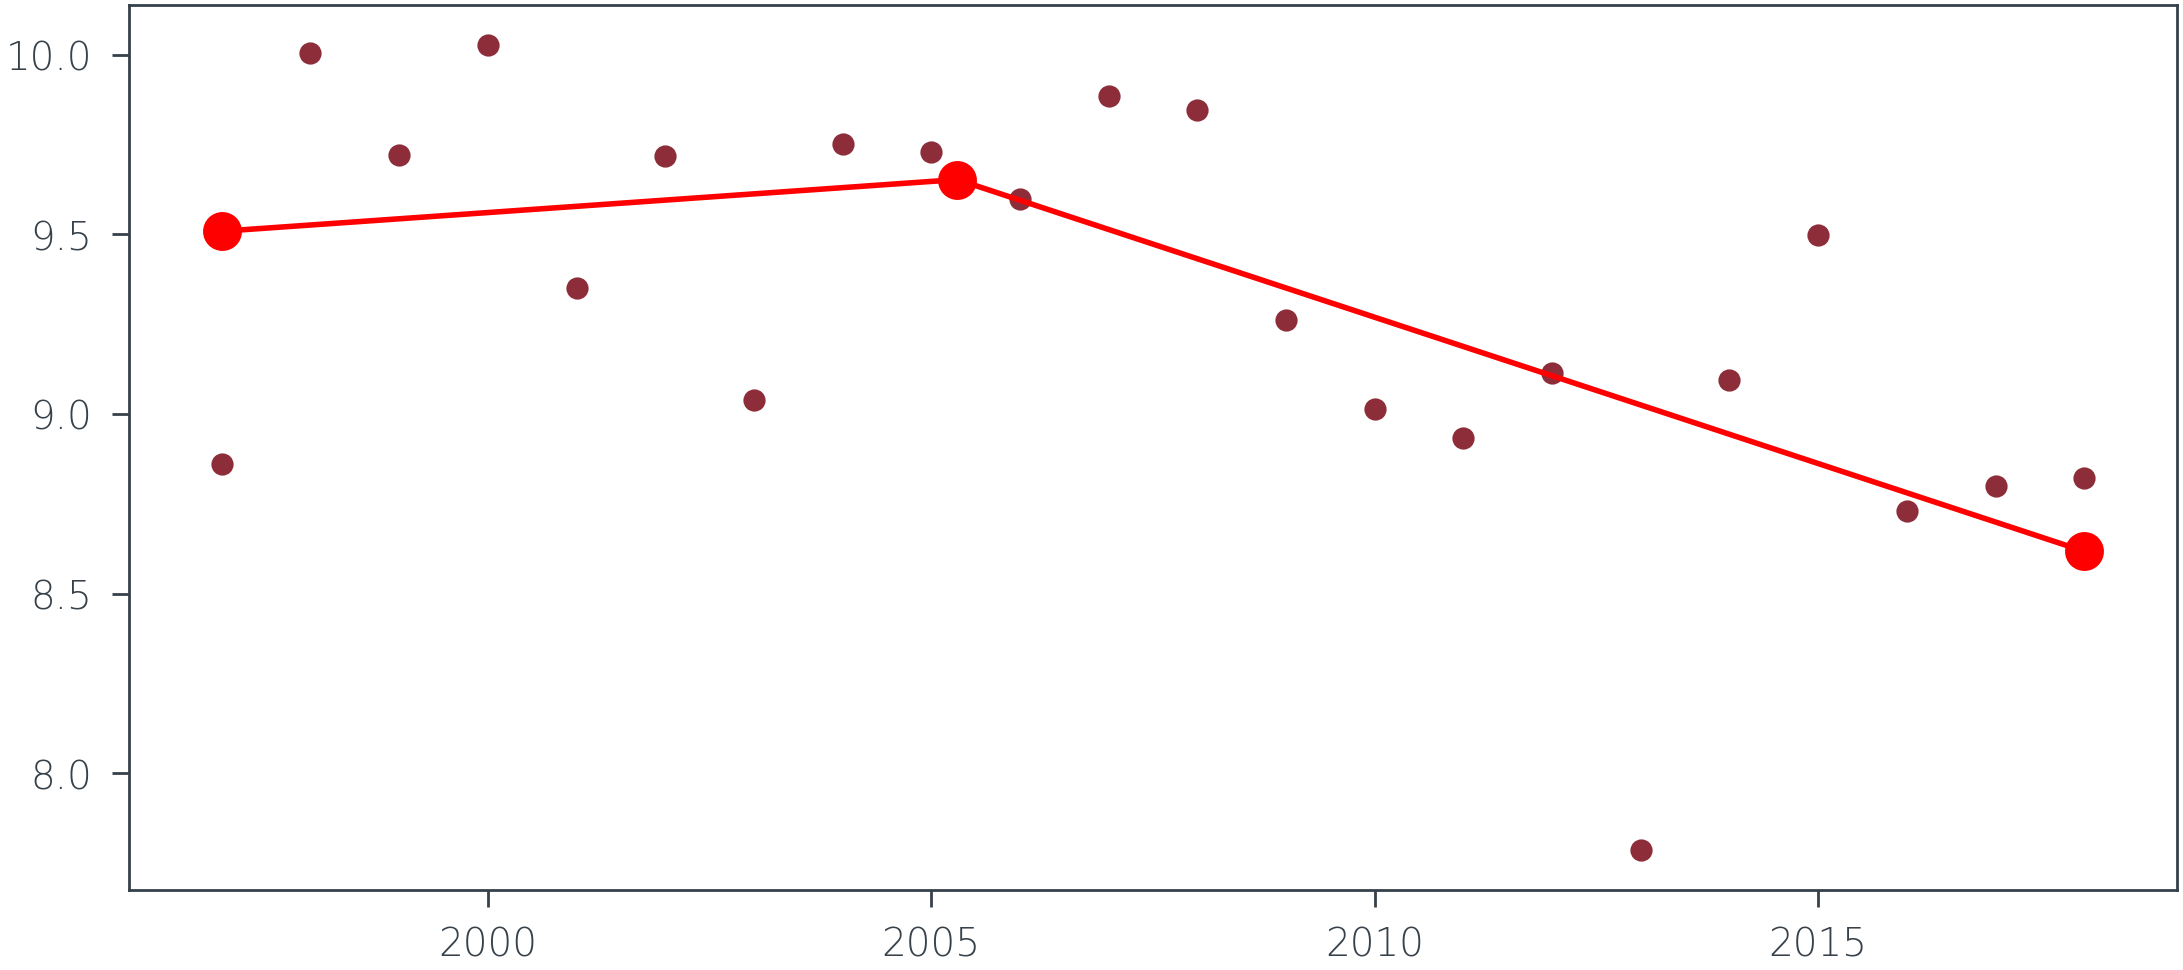

In [ ]:
X = yearly_df[yearly_df.index < 2019].index
Y= yearly_df[yearly_df.index < 2019]['param_lambda']

px, py = segments_fit(X, Y, 2)
Y2 = np.interp(X, px, py)
print(np.sqrt(np.mean((Y - Y2)**2)))
plt.plot(X, Y, ".")
plt.plot(px, py, "-or")
plt.show()

